In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import re
from datetime import timedelta
from datetime import datetime as dt
import json
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

import jieba
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim import corpora, models, similarities

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models # don't skip this
import matplotlib.pyplot as plt

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from wordcloud import WordCloud
from snownlp import SnowNLP
from cemotion import Cemotion

import umap.umap_ as umap
#import hdbscan
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

###kmeans

from sklearn.cluster import KMeans
import sys
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn import metrics

2024-05-24 09:52:14.414213: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.

Bad key text.latex.preview in file /Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an u

original csv read and preprocess and persist

In [3]:
for inputfile in os.listdir(r'/Users/luoqk/Downloads/inputFileDir'):
    dfa = pd.read_csv(r'/Users/luoqk/Downloads/inputFileDir/'+inputfile, header=None)
    dfa.to_csv('0-290.csv', mode='a', index=False, header=False)

/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (0,3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [12]:
originalData = pd.read_csv('/Users/luoqk/Downloads/inputFileDir/dialogue101-190.csv')
originalData.drop(columns=['Unnamed: 0'], inplace=True)
originalData = originalData.rename(columns={'Unnamed: 0.1':'num'})

In [ ]:
originalData.head(20)

In [13]:
def format(dataOri):
    idx = 0
    ask_list, answer_list, checkin_list, info_list = list(), list(), list(), list()
    #complaint_list, record_list, advice_list
    last_mod = ''
    dialogue = pd.DataFrame(columns=['num', 'lastMod', 'askList', 'answerList', 'checkInList', 'complaint', 'record', 'advice', 'patientInfo', 'consultingType', 'patientVote', 'onlineCons'])
    for i in range(len(dataOri)-1):
        if pd.isnull(dataOri.lastMod[i]) == False and dataOri.lastMod[i] != 'nan' and dataOri.lastMod[i] != '0':
            last_mod = dataOri.lastMod[i]
            if len(re.findall('\.', last_mod)) == 1:
                last_mod = '2022.' + last_mod
            info_list.append(dataOri.diseaseInfoList[i])
            info_list.append(dataOri.recordSum[i])
            info_list.append(dataOri.dispAdvice[i])
            info_list.append(dataOri.patientAge[i])
            info_list.append(dataOri.type[i])
            info_list.append(dataOri.patientVote[i])
            info_list.append(dataOri.onlineCons[i])
        if pd.isnull(dataOri.askList[i]) == False and dataOri.askList[i] != 'nan' and dataOri.askList[i] != '0':
            ask_list.append(dataOri.askList[i])
        if pd.isnull(dataOri.answerList[i]) == False and dataOri.answerList[i] != 'nan' and dataOri.answerList[i] != '0':
            answer_list.append(dataOri.answerList[i])
        if pd.isnull(dataOri.checkInList[i]) == False and dataOri.checkInList[i] != 'nan' and dataOri.checkInList[i] != '0':
            checkin_list.append(dataOri.checkInList[i])

        if dataOri.loc[i+1,'num'] == 0:   
            temp = pd.DataFrame([[idx, last_mod, ask_list, answer_list, checkin_list, 
            info_list[0], 
            info_list[1],
            info_list[2],
            info_list[3],
            info_list[4],
            info_list[5],
            info_list[6]]], columns=dialogue.columns.values)
            dialogue = pd.concat([dialogue, temp], axis=0)
            #dialogue = dialogue.append(temp)
            ask_list, answer_list, checkin_list, info_list =list(), list(), list(), list()
            last_mod = ''
            idx += 1
        else:
            continue

    i = len(dataOri)-1
    if pd.isnull(dataOri.lastMod[i]) == False and dataOri.lastMod[i] != 'nan' and dataOri.lastMod[i] != '0':
        last_mod = dataOri.lastMod[i]
        if len(re.findall('\.', last_mod)) == 1:
            last_mod = '2022.' + last_mod
        info_list.append(dataOri.diseaseInfoList[i])
        info_list.append(dataOri.recordSum[i])
        info_list.append(dataOri.dispAdvice[i])
        info_list.append(dataOri.patientAge[i])
        info_list.append(dataOri.type[i])
        info_list.append(dataOri.patientVote[i])
        info_list.append(dataOri.onlineCons[i])
    if pd.isnull(dataOri.askList[i]) == False and dataOri.askList[i] != 'nan' and dataOri.askList[i] != '0':
        ask_list.append(dataOri.askList[i])
    if pd.isnull(dataOri.answerList[i]) == False and dataOri.answerList[i] != 'nan' and dataOri.answerList[i] != '0':
        answer_list.append(dataOri.answerList[i])
    if pd.isnull(dataOri.checkInList[i]) == False and dataOri.checkInList[i] != 'nan' and dataOri.checkInList[i] != '0':
        checkin_list.append(dataOri.checkInList[i])
    
    temp = pd.DataFrame([[idx, last_mod, ask_list, answer_list, checkin_list, 
        info_list[0], 
        info_list[1],
        info_list[2],
        info_list[3],
        info_list[4],
        info_list[5],
        info_list[6],]], columns=dialogue.columns.values)
    dialogue = pd.concat([dialogue, temp], axis=0)

    dialogue['lastMod'] = pd.to_datetime(dialogue['lastMod'].astype(str), format='%Y.%m.%d')
    #dialogue = dialogue.dropna()
    dialogue = dialogue.reset_index(drop=True)
    #dialogue = dialogue.drop(columns='num')
    return dialogue

try:
    dialogue = format(originalData)
    dialogue.to_csv('dialogue.csv')
except Exception as e:
    print("exception", e)

exception 'DataFrame' object has no attribute 'diseaseInfoList'


In [31]:
dialogue = pd.read_csv('dialogue101-190.csv', dtype=object)
dialogue.reset_index(drop=True, inplace=True)
dialogue.drop(columns=['Unnamed: 0'], inplace=True)

In [32]:
dialogue = dialogue.groupby(dialogue['lastMod']).filter(lambda x:(x.askList != '[]').all())

In [33]:
dialogue.to_csv('10w_test.csv')

构建时间特征

In [2]:
dialogue = pd.read_csv('10w_test.csv')

In [5]:
dialogue.reset_index(drop=True, inplace=True)
dialogue.drop(columns=['Unnamed: 0'], inplace=True)
dialogue = dialogue.groupby(dialogue['lastMod']).filter(lambda x:(x.askList != '[]').all())
dialogue.describe()

,num
count,4.308300e+04
mean,1.424647e+06
std,8.248069e+05
min,1.650000e+02
25%,7.081245e+05
50%,1.428773e+06
75%,2.138810e+06
max,2.844976e+06


In [6]:
dialogue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43083 entries, 0 to 43082
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   num             43083 non-null  int64 
 1   lastMod         43083 non-null  object
 2   askList         43083 non-null  object
 3   answerList      43083 non-null  object
 4   checkInList     43083 non-null  object
 5   complaint       43083 non-null  object
 6   record          43083 non-null  object
 7   advice          43083 non-null  object
 8   patientInfo     43083 non-null  object
 9   consultingType  43083 non-null  object
 10  patientVote     43083 non-null  object
 11  onlineCons      43083 non-null  object
dtypes: int64(1), object(11)
memory usage: 4.3+ MB


45w with checkin 1 times items

temporal feature: askLagTotal, answerLagTotal, checkInLag, checkInTitle, checkInType, withOffLine， timesCheckIn
feature: askFreq, answerFreq, checkInFreq

In [7]:
dialogue['askLagTotal'] = ''
# 对话中患者问诊时间跨度

dialogue['answerLagTotal'] = ''
# 对话中医师回话时间跨度

dialogue['checkInLag'] = ''
dialogue['checkInTitle'] = ''
dialogue['checkInType'] = ''
# 线上报到时间跨度/题目/类型

dialogue['withOffLine'] = ''
dialogue['timesCheckIn'] = ''
dialogue['askFreq'] = ''
dialogue['answerFreq'] = ''
dialogue['checkInFreq'] = ''

for i in range(len(dialogue)):
    try:
        dialogue['askList'][i] = eval(dialogue['askList'][i])
        dialogue['answerList'][i] = eval(dialogue['answerList'][i])
        dialogue['checkInList'][i] = eval(dialogue['checkInList'][i])
        dialogue['complaint'][i] = eval(dialogue['complaint'][i])
        dialogue['record'][i] = eval(dialogue['record'][i])
        dialogue['advice'][i] = eval(dialogue['advice'][i])

        ruleStr = r'\[\'(.*?)\'\]'
        timelineLag1, timelineLag2, timelineLag3, checkInTitle, checkInType = list(), list(), list(), list(), list()
        # 如果语音回话，语音时间
        if dialogue['askList'][i]:
            for j in range(len(dialogue['askList'][i])): 
                timelineStr = dialogue['askList'][i][j]

                timeline = str(re.findall(ruleStr, timelineStr)[0])
                if len(re.findall('\.', timeline)) == 1:
                    timeline = '2022.' + timeline
            
                tl1 = ''
                if str(timeline) == '昨天':
                    tl1 = dialogue.lastMod[i] - timedelta(days=1)
                if str(timeline) == '明天':
                    tl1 = dialogue.lastMod[i] + timedelta(days=1)
                if str(timeline) == '今天':
                    tl1 = dialogue.lastMod[i]
                if tl1 != '':
                    timeline = pd.to_datetime(tl1)
                timeline = pd.to_datetime(timeline)
                timelineLag1.append(timeline)
            deltaAskTime = timelineLag1[len(timelineLag1)-1] - timelineLag1[0]
            dialogue['askLagTotal'][i] = deltaAskTime.days
        if dialogue['answerList'][i]:
            for j in range(len(dialogue['answerList'][i])): 
                timelineStr2 = dialogue['answerList'][i][j]
                timeline2 = str(re.findall(ruleStr, timelineStr2)[0])
                if len(re.findall(r'\.', timeline2)) == 1:
                    timeline2 = '2022.' + timeline2
                    timeline2 = pd.to_datetime(timeline2)
                tl2 = ''
                if str(timeline2) == '昨天':
                    tl2 = dialogue.lastMod[i] - timedelta(days=1)
                if str(timeline2) == '明天':
                    tl2 = dialogue.lastMod[i] + timedelta(days=1)
                if str(timeline2) == '今天':
                    tl2 = dialogue.lastMod[i]
                if tl2 != '':
                    timeline2 = pd.to_datetime(tl2)
            
                timeline2 = pd.to_datetime(timeline2)
                timelineLag2.append(timeline2)
            deltaAnswerTime = timelineLag2[len(timelineLag2)-1] - timelineLag2[0]
            dialogue['answerLagTotal'][i] = deltaAnswerTime.days
        if dialogue['checkInList'][i]:
            for j in range(len(dialogue['checkInList'][i])): 
                timelineStr3 = dialogue['checkInList'][i][j]

                topicEach = str(re.findall(ruleStr, timelineStr3)[0])
                checkInTitle.append(topicEach)
                timeline3 = str(re.findall(ruleStr, timelineStr3)[1])
                if len(re.findall(r'\-', timeline3)) == 1:
                    timeline3 = '2022-' + timeline3
                typeEach = str(re.findall(ruleStr, timelineStr3)[2]) 
                checkInType.append(typeEach)   
                timeline3 = pd.to_datetime(timeline3)
                timelineLag3.append(timeline3)
            checkInLagList = list()
            for item in timelineLag3:
                checkInLagList.append((item - pd.to_datetime(dialogue.lastMod[i])).days)
                dialogue['checkInLag'][i] = checkInLagList
            dialogue['checkInTitle'][i] = checkInTitle
            dialogue['checkInType'][i] = checkInType

    except Exception as e:
        print(e)
        print(i)

for i in range(len(dialogue)):
    dialogue['askFreq'][i] = len(dialogue['askList'][i])
    dialogue['answerFreq'][i] = len(dialogue['answerList'][i])
    dialogue['checkInFreq'][i] = len(dialogue['checkInList'][i])

    if len(dialogue['askList'][i]) == 0:
        dialogue['askList'][i] = '无'
    if len(dialogue['answerList'][i]) == 0:
        dialogue['answerList'][i] = '无'

    if len(dialogue['checkInList'][i]) == 0:
        dialogue['withOffLine'][i] = 0
        dialogue['timesCheckIn'][i] = 0
    else:
        dialogue['withOffLine'][i] = 1
        dialogue['timesCheckIn'][i] = len(dialogue['checkInList'][i])

dialogue = dialogue.groupby(dialogue['withOffLine']).filter(lambda x:(x.withOffLine == 1).all())

dialogue[['askLagTotal']] = dialogue[['askLagTotal']].fillna('').replace('', 999).abs()
dialogue[['answerLagTotal']] = dialogue[['answerLagTotal']].fillna('').replace('', 999).abs()

dialog = dialogue.copy()

#dialog.to_csv('45w_dialog.csv')
#dialog.to_csv('5w_test.csv')

/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/luoqk/opt/anaconda3/e

KeyboardInterrupt: 

In [ ]:
dialog.to_csv('10w_test.csv')

dialogue --> dialog with jsonlized

In [13]:
dialog = pd.read_csv('10w_test.csv')
dialog.reset_index(drop=True, inplace=True)
dialog.drop(columns=['Unnamed: 0', 'num'], inplace=True)

In [15]:
dialog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43083 entries, 0 to 43082
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   lastMod         43083 non-null  object
 1   askList         43083 non-null  object
 2   answerList      43083 non-null  object
 3   checkInList     43083 non-null  object
 4   complaint       43083 non-null  object
 5   record          43083 non-null  object
 6   advice          43083 non-null  object
 7   patientInfo     43083 non-null  object
 8   consultingType  43083 non-null  object
 9   patientVote     43083 non-null  object
 10  onlineCons      43083 non-null  object
dtypes: object(11)
memory usage: 3.6+ MB


In [16]:
dialog.describe()

,lastMod,askList,answerList,checkInList,complaint,record,advice,patientInfo,consultingType,patientVote,onlineCons
count,43083,43083,43083,43083,43083,43083,43083,43083,43083,43083,43083
unique,1720,42262,42048,30,42155,3,3,21153,4,1118,7704
top,2011-08-04,"[""[[0, ['2010.11.20'], [('病情描述（发病时间、主要症状、就诊医院等...","[""[[0, ['2010.05.29'], [], [('', '', '隐私内容，仅主诊...",[],"[[['肺腺癌术后头部转移、肺部复发、腰椎转移', '', '病情描述（发病时间、主要症状、...",0,0,['l*** 女 30岁'],[' - 图文问诊'],['暂无'],['25912']
freq,189,3,6,43054,3,43080,43080,50,42948,10390,516


In [39]:
for i in range(len(dialog)):
    try:
        # dialog['askList'][i] = eval(dialog['askList'][i])
        # dialog['answerList'][i] = eval(dialog['answerList'][i])
        # dialog['checkInList'][i] = eval(dialog['checkInList'][i])
        # dialog['complaint'][i] = eval(dialog['complaint'][i])
        # dialog['record'][i] = eval(dialog['record'][i])
        # dialog['advice'][i] = eval(dialog['advice'][i])
    
        jsonAsk = json.dumps(dialog['askList'][i],ensure_ascii=False) 
        jsonAnswer = json.dumps(dialog['answerList'][i],ensure_ascii=False)
        jsonCheckIn = json.dumps(dialog['checkInList'][i], ensure_ascii=False)

        jsonComplaint = json.dumps(dialog['complaint'][i],ensure_ascii=False)
        jsonRecord = json.dumps(dialog['record'][i],ensure_ascii=False)
        jsonAdvice = json.dumps(dialog['advice'][i],ensure_ascii=False)
        jsonVote = json.dumps(dialog['patientVote'][i],ensure_ascii=False)
        jsonCons = json.dumps(dialog['onlineCons'][i],ensure_ascii=False)

        ask = json.loads(jsonAsk)
        answer = json.loads(jsonAnswer)
        checkIn = json.loads(jsonCheckIn)
        complaint1 = json.loads(jsonComplaint)
        record1 = json.loads(jsonRecord)
        advice1 = json.loads(jsonAdvice)
        vote1 = json.loads(jsonVote)
        cons1 = json.loads(jsonCons)

        ask = re.sub('[^\u4e00-\u9fa5]+', '', str(ask))
        answer = re.sub('[^\u4e00-\u9fa5]+', '', str(answer))
        checkIn = re.sub('[^\u4e00-\u9fa5]+', '', str(checkIn))
        complaint1 = re.sub('[^\u4e00-\u9fa5]+', '', str(complaint1))
        record1 = re.sub('[^\u4e00-\u9fa5]+', '', str(record1))
        advice1 = re.sub('[^\u4e00-\u9fa5]+', '', str(advice1))

        # 保留数字
        vote1 = re.findall('\d+', str(vote1))
        cons1 = re.findall('\d+', str(cons1))

        dialog['askList'][i] = ask
        dialog['answerList'][i] = answer
        dialog['checkInList'][i] = checkIn
        dialog['complaint'][i] = complaint1
        dialog['record'][i] = record1
        dialog['advice'][i] = advice1
        dialog['patientVote'][i] = vote1
        dialog['onlineCons'][i] = cons1
    except Exception as e:
        print(e)
        print(i)

dialog.to_csv('10w_test_text.csv')

satisficing, patientvote, onlinecons, items with QA lag less than 1 years (45w to 38w)

In [ ]:

dialog['satisficing'] = ''
for i in range(len(dialog)):
    if dialog['patientVote'][i] == []:
        dialog['patientVote'][i] = "['0']"
    if dialog['onlineCons'][i] == []:
        dialog['onlineCons'][i] = "['9999']"
    dialog['satisficing'][i] = pd.to_numeric(re.findall('\d+', str(dialog['patientVote'][i]))[0])/pd.to_numeric(re.findall('\d+', str(dialog['onlineCons'][i]))[0])
# dtl['satisficing'] = dtl.apply(lambda x: pd.to_numeric(dtl['patientVote']) / pd.to_numeric(dtl['onlineCons']), axis=1) 

for i in range(len(dialog)):
    dialog['patientVote'][i] = pd.to_numeric(re.findall('\d+', str(dialog['patientVote'][i]))[0])
    dialog['onlineCons'][i] = pd.to_numeric(re.findall('\d+', str(dialog['onlineCons'][i]))[0])

#snsCondition1 = dtl.askLagTotal.values == 0
#snsCondition2 = dtl.answerLagTotal.values == 0
#dtl = dtl.drop(dtl[(snsCondition1)|(snsCondition2)].index)
snsCondition3 = dialog.askLagTotal.values > 365
snsCondition4 = dialog.answerLagTotal.values > 365
dialog = dialog.drop(dialog[(snsCondition3)|(snsCondition4)].index)

/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

lookbacktype, lookbacklag, lookaheadtype, lookaheadlag

In [ ]:
dialog['lookBackType1'] = ''
dialog['lookBackLag1'] = ''
dialog['lookBackType2'] = ''
dialog['lookBackLag2'] = ''
dialog['lookBackType3'] = ''
dialog['lookBackLag3'] = ''
dialog['lookAheadType'] = ''
dialog['lookAheadLag'] = ''
listLookBack, listLookAhead = list(), list()

for i in range(len(dialog)):
    try:
        a = re.findall(r'\'(.*?)\'', str(dialog.checkInType.values[i]))
        b = re.findall(r'\-?\d+', str(dialog.checkInLag.values[i]))
        if len(a) == len(b):
            for j in range(len(b)):
                if int(b[j]) < 0:
                    listLookBack.append([int(b[j]),a[j]])
                else:
                    listLookAhead.append([int(b[j]),a[j]])
            lll = len(listLookAhead)
            if lll != 0:
                dialog['lookAheadLag'][i] = listLookAhead[-1][0]
                dialog['lookAheadType'][i] = listLookAhead[-1][1]
            else:
                dialog['lookAheadLag'][i] = ''
                dialog['lookAheadType'][i] = ''
            ll = len(listLookBack)
            if ll == 1:
                dialog['lookBackLag1'][i] = listLookBack[-1][0]
                dialog['lookBackType1'][i] = listLookBack[-1][1]
            else:
                dialog['lookBackLag1'][i] = ''
                dialog['lookBackType1'][i] = ''
            if ll == 2:
                dialog['lookBackLag2'][i] = listLookBack[-1][0]
                dialog['lookBackType2'][i] = listLookBack[-1][1]
            else:
                dialog['lookBackLag2'][i] = ''
                dialog['lookBackType2'][i] = ''
            if ll == 3:
                dialog['lookBackLag3'][i] = listLookBack[-1][0]
                dialog['lookBackType3'][i] = listLookBack[-1][1]
            else:
                dialog['lookBackLag3'][i] = ''
                dialog['lookBackType3'][i] = ''
        listLookBack, listLookAhead = list(), list()
    except TypeError:
        print(i, dialog.checkInType.values[i])
        continue

    #if len(dtl['checkInLag'][i]) >= 1:    

# dialog['lookBackLag1'] = dialog.lookBackLag1.replace('', -999).astype(int)
# dialog['lookBackLag2'] = dialog.lookBackLag2.replace('', -999).astype(int)
# dialog['lookBackLag3'] = dialog.lookBackLag3.replace('', -999).astype(int)
# dialog['lookAheadLag'] = dialog.lookAheadLag.replace('', 999).astype(int)
dialog['lookBackLag1'] = dialog.lookBackLag1.replace('', -9999).astype(int)
dialog['lookBackLag2'] = dialog.lookBackLag2.replace('', -9999).astype(int)
dialog['lookBackLag3'] = dialog.lookBackLag3.replace('', -9999).astype(int)
dialog['lookAheadLag'] = dialog.lookAheadLag.replace('', 9999).astype(int)

dialog.to_csv('reframed_temporal.csv')

/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/luoqk/opt/anaconda3/e

In [17]:
dialog= pd.read_csv('reframed_temporal.csv', index_col=0)

date, patient sex and age, consultingType

In [18]:
dialog= pd.read_csv('reframed_temporal.csv', index_col=0)
dialog.reset_index(inplace=True)

dialog['patientSex'] = ''
dialog['patientAge'] = ''

for i in range(len(dialog)):
    dialog['lastMod'][i] = dt.strptime(dialog['lastMod'][i], '%Y-%m-%d')
    dialog['consultingType'][i] = re.findall(r'[\u4e00-\u9fa5]+', str(dialog['consultingType'][i]))[0]
    sexStr = dialog['patientInfo'][i]
    dialog['patientSex'][i] = '' if sexStr == '' else re.findall(r'\s(.*?)\s(.*?)\'\]', str(sexStr))[0][0]
    genderStr = re.findall(r'\s(.*?)\s(.*?)\'\]', str(dialog['patientInfo'][i]))[0][1]
    dialog['patientAge'][i] = '' if genderStr == '' else re.findall(r'\d+', str(genderStr))[0]

dialog['patientAge'] = dialog.patientAge.replace('', -1).astype(int)

dialog.drop(columns=['patientInfo'], axis=1, inplace=True)

dialog.to_csv('5w_reframed_temporal_2.csv')

/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

KeyboardInterrupt: 

serialize the type features with domain-specific categories

In [19]:
dialog = pd.read_csv('5w_reframed_temporal_2.csv', index_col=0)
dialog['lookBackLag1'] = dialog.lookBackLag1.fillna(-9999)
dialog['lookBackLag2'] = dialog.lookBackLag2.fillna(-9999)
dialog['lookBackLag3'] = dialog.lookBackLag3.fillna(-9999)
dialog['lookAheadLag'] = dialog.lookAheadLag.fillna(9999)

#dialog.fillna('', inplace=True)

### 图文（图文问诊）（60元/2天）Cat1
### 电话（极速电话） （100元/10分钟）Cat2
### 问答（一问一答） （30元）Cat3
### 扫码报到 Cat4
### 门诊  Cat5
### 复诊（线下就诊线上复诊） Cat6
### 其他小众 Cat7
### 无 Cat0
typeFeature = ['consultingType','lookBackType1','lookBackType2','lookBackType3','lookAheadType']
dialog['consultingType_'] = 'Cat7'
dialog['lookBackType1_'] = 'Cat7'
dialog['lookBackType2_'] = 'Cat7'
dialog['lookBackType3_'] = 'Cat7'
dialog['lookAheadType_'] = 'Cat7'
typeFeature_ = ['consultingType_','lookBackType1_','lookBackType2_','lookBackType3_','lookAheadType_']
for i in range(len(typeFeature)):
    dialog.loc[dialog[typeFeature[i]].isna(), typeFeature_[i]] = 'Cat0'
    dialog.loc[dialog[typeFeature[i]].str.contains('门诊', na=False), typeFeature_[i]] = 'Cat5'
    dialog.loc[dialog[typeFeature[i]].str.contains('复诊', na=False), typeFeature_[i]] = 'Cat6'
    dialog.loc[dialog[typeFeature[i]].str.contains('报到', na=False), typeFeature_[i]] = 'Cat4'
    dialog.loc[dialog[typeFeature[i]].str.contains('一答', na=False), typeFeature_[i]] = 'Cat3'
    dialog.loc[dialog[typeFeature[i]].str.contains('电话', na=False), typeFeature_[i]] = 'Cat2'
    dialog.loc[dialog[typeFeature[i]].str.contains('图文', na=False), typeFeature_[i]] = 'Cat1'
    
    #reframedData.loc[reframedData[typeFeature[i]].str.contains('Cat') == False, typeFeature_[i]] = 'Cat7'

dialog.drop(columns=['index', 'consultingType', 'lookBackType1', 'lookBackType2', 'lookBackType3', 'lookAheadType'], axis=1, inplace=True)

In [20]:
dialog.describe()

,patientVote,onlineCons,askLagTotal,answerLagTotal,withOffLine,timesCheckIn,askFreq,answerFreq,checkInFreq,satisficing,lookBackLag1,lookBackLag2,lookBackLag3,lookAheadLag,patientAge
count,10617.000000,10617.000000,10617.000000,10617.000000,10617.0,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000
mean,384.744372,7296.908543,5.716492,10.199397,1.0,2.925026,6.764434,6.297824,2.925026,0.056106,-6582.694923,-8965.444005,-9498.586701,4879.239522,30.914100
std,559.769088,9106.017987,24.393253,35.044926,0.0,3.703146,4.002847,2.707797,3.703146,0.059955,4666.835518,2996.202776,2143.007710,4945.562947,19.731166
min,0.000000,2.000000,0.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.000000,-9999.000000,-9999.000000,-9999.000000,0.000000,1.000000
25%,40.000000,1533.000000,0.000000,0.000000,1.0,1.000000,3.000000,4.000000,1.000000,0.020202,-9999.000000,-9999.000000,-9999.000000,44.000000,13.000000
50%,178.000000,4218.000000,0.000000,2.000000,1.0,2.000000,7.000000,6.000000,2.000000,0.045198,-9999.000000,-9999.000000,-9999.000000,498.000000,31.000000
75%,485.000000,9658.000000,2.000000,4.000000,1.0,3.000000,10.000000,8.000000,3.000000,0.075523,-188.000000,-9999.000000,-9999.000000,9999.000000,43.000000
max,4474.000000,89028.000000,363.000000,365.000000,1.0,50.000000,19.000000,18.000000,50.000000,2.200000,-1.000000,-1.000000,-3.000000,9999.000000,121.000000


In [ ]:
dialog.consultingType_.value_counts()

Cat1    8490
Cat2    1508
Cat3     399
Cat7     137
Cat6      69
Cat5       7
Cat4       7
Name: consultingType_, dtype: int64

In [ ]:
#dialog1 = pd.read_csv('normalized_38w.csv', index_col=0)

In [ ]:
#dialog = pd.read_csv('38w_reframed_temporal_2.csv', index_col=0)
#ttt =list(dialog['lookAheadType'].value_counts().index)
# ['其他/小众/个性化'Cat0,'图文问诊'Cat1,'复诊'Cat6,'极速电话'Cat2,'一问一答'Cat3,'诊后报到'Cat4,'门诊'Cat5]

文本特征txt asktext, answerText, checkInText, complainText, recordText, adviceText, checkInTitleText

In [ ]:
dialog['askList'].to_csv('textFile/askText_5w.txt')
dialog['answerList'].to_csv('textFile/answerText_5w.txt')
dialog['checkInList'].to_csv('textFile/checkInText_5w.txt')
dialog['complaint'].to_csv('textFile/complaintText_5w.txt')
dialog['record'].to_csv('textFile/recordText_5w.txt')
dialog['advice'].to_csv('textFile/adviceText_5w.txt')
dialog['checkInTitle'].to_csv('textFile/checkInTitleText_5w.txt')

In [ ]:
# snsCondition5 = dialog[['lookBackLag1']].abs() > 999
# snsCondition6 = dialog[['lookBackLag2']].abs() > 999
# snsCondition7 = dialog[['lookBackLag3']].abs() > 999
# dialog = dialog.drop(dialog[(snsCondition5)|(snsCondition6)|(snsCondition7)].index)

In [ ]:
dialog = dialog.drop(columns=['askList', 'answerList', 'checkInList', 'complaint', 'record', 'advice',
                              'timesCheckIn', 'withOffLine', 'checkInTitle', 'askLagTotal', 'answerLagTotal', 'checkInLag', 'checkInType'])
for i in range(len(dialog)):
    dialog['patientVote'][i] = pd.to_numeric(re.findall('\d+', str(dialog['patientVote'][i]))[0])
    dialog['onlineCons'][i] = pd.to_numeric(re.findall('\d+', str(dialog['onlineCons'][i]))[0])

/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
dialog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10617 entries, 0 to 10616
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   lastMod          10617 non-null  object 
 1   patientVote      10617 non-null  int64  
 2   onlineCons       10617 non-null  int64  
 3   askFreq          10617 non-null  int64  
 4   answerFreq       10617 non-null  int64  
 5   checkInFreq      10617 non-null  int64  
 6   satisficing      10617 non-null  float64
 7   lookBackLag1     10617 non-null  int64  
 8   lookBackLag2     10617 non-null  int64  
 9   lookBackLag3     10617 non-null  int64  
 10  lookAheadLag     10617 non-null  int64  
 11  patientSex       10617 non-null  object 
 12  patientAge       10617 non-null  int64  
 13  consultingType_  10617 non-null  object 
 14  lookBackType1_   10617 non-null  object 
 15  lookBackType2_   10617 non-null  object 
 16  lookBackType3_   10617 non-null  object 
 17  lookAheadTyp

structural feature normalized engineering

In [ ]:
dialog.to_csv('preprocessedDialog.csv')

In [ ]:
X = dialog[["lookAheadType_","consultingType_","lookBackType1_","lookBackType2_","lookBackType3_","patientSex"]]

le1 = LabelEncoder()
le2 = LabelEncoder()
le3 = LabelEncoder()
le4 = LabelEncoder()
le5 = LabelEncoder()
le6 = LabelEncoder()

X['lookAheadType_'] = le1.fit_transform(X['lookAheadType_'])
X['consultingType_'] = le2.fit_transform(X['consultingType_'])
X['lookBackType1_'] = le3.fit_transform(X['lookBackType1_'])
X['lookBackType2_'] = le4.fit_transform(X['lookBackType2_'])
X['lookBackType3_'] = le5.fit_transform(X['lookBackType3_'])
X['patientSex'] = le6.fit_transform(X['patientSex'])


/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value 

In [ ]:
Xtt = X.apply(str)

In [ ]:
from gensim.models import word2vec
vector_length = 10
model = word2vec.Word2Vec(Xtt, vector_size = vector_length, window=2, workers=4)

In [ ]:
import numpy as np
embedding_matrix = np.zeros((8, vector_length))
for i in range(1, 8):
    embedding_matrix[i] = model.wv[str(i)]

In [ ]:
X.describe()

,lookAheadType_,consultingType_,lookBackType1_,lookBackType2_,lookBackType3_,patientSex
count,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000
mean,0.801074,0.331732,0.913817,0.279740,0.132147,0.413865
std,1.194683,0.908784,1.548030,0.944143,0.653637,0.492548
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,7.000000,6.000000,6.000000,6.000000,6.000000,1.000000


In [ ]:
from sklearn.model_selection import train_test_split
dataList_x=  X.iloc[:,:-1].values.tolist()
dataList_y = X.iloc[:,-1].values.tolist()
x_train, x_cv, y_train, y_cv = train_test_split(dataList_x,dataList_y,test_size = 0.25,train_size =0.75)

In [ ]:
#from keras.preprocessing import sequence
from keras.utils.data_utils import pad_sequences
#from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len = 4
x_train = pad_sequences(dataList_x, maxlen=max_len)
x_cv = pad_sequences(x_cv, maxlen=max_len)
y_train = np.array(dataList_y)
y_cv = np.array(y_cv)
print(x_train.shape, y_train.shape)
print(x_cv.shape, y_cv.shape)

(10617, 4) (10617,)
(2655, 4) (2655,)


In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, MaxPooling1D, Convolution1D, Embedding, BatchNormalization, Activation
from keras import optimizers

embedding_dim = 10

embedding_layer = Embedding(input_dim=embedding_matrix.shape[0],
                            output_dim = embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=True)

In [ ]:
from keras.layers import Concatenate

NUM_EPOCHS = 100
BATCH_SIZE = 64
DROP_PORB = (0.5, 0.8)
NUM_FILTERS = (64, 32)
FILTER_SIZES = (1, 2, 3)
HIDDEN_DIMS = 1024
FEATURE_DIMS = 256
ACTIVE_FUNC = 'relu'

sequence_input = Input(shape=(max_len, ), dtype='int32')
embedded_seq = embedding_layer(sequence_input)

# Convolutional block
conv_blocks = []
for size in FILTER_SIZES:
    conv = Convolution1D(filters=NUM_FILTERS[0],
                         kernel_size=size,
                         padding="valid",
                         activation=ACTIVE_FUNC,
                         strides=1)(embedded_seq)
    conv = Convolution1D(filters=NUM_FILTERS[1],
                         kernel_size=2,
                         padding="valid",
                         activation=ACTIVE_FUNC,
                         strides=1)(conv)
    conv = Flatten()(conv)
    conv_blocks.append(conv)

model_tmp = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
model_tmp = Dropout(DROP_PORB[1])(model_tmp)
model_tmp = Dense(HIDDEN_DIMS, activation=ACTIVE_FUNC)(model_tmp)
model_tmp = Dropout(DROP_PORB[0])(model_tmp)
model_tmp = Dense(FEATURE_DIMS, activation=ACTIVE_FUNC)(model_tmp)
model_tmp = Dropout(DROP_PORB[0])(model_tmp)
model_output = Dense(1, activation="sigmoid")(model_tmp)
model = Model(sequence_input, model_output)

opti = optimizers.SGD(lr = 0.01, momentum=0.8, decay=0.0001)

model.compile(loss='binary_crossentropy',
              optimizer = opti,
              metrics=['binary_accuracy'])

model.fit(x_train, y_train, batch_size = BATCH_SIZE, validation_data = (x_cv, y_cv))


/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2023-09-09 16:04:17,610 : WARNING : AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x7f7d794e8290> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
161/166 [============================>.] - ETA: 0s - loss: 0.6812 - binary_accuracy: 0.5844WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f7d79227290> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2023-09-09 16:04:21,204 : WARNING : AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f7d79227290> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
166/166 [==============================] - 4s 13ms/step - loss: 0.6811 - binary_accuracy: 0.5844 - val_loss: 0.6769 - val_binary_accuracy: 0.5906


In [ ]:
from sklearn import metrics
for i in range(NUM_EPOCHS):
    model.fit(x_train, y_train, batch_size = BATCH_SIZE, validation_data = (x_cv, y_cv))
    y_pred = model.predict(x_cv)
    val_auc = metrics.roc_auc_score(y_cv, y_pred)
    print('val_auc:{0:5f}'.format(val_auc))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2023-09-09 16:09:31,124 : WARNING : AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x7f7e376053b0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
166/166 [==============================] - ETA: 0s - loss: 0.6794 - accuracy: 0.5858WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f7d7a443b90> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2023-09-09 16:09:43,183 : WARNING : AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f7d7a443b90> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
166/166 [==============================] - 13s 42ms/step - loss: 0.6794 - accuracy: 0.5858 - val_loss: 0.6769 - val_accuracy: 0.5906
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2023-09-09 16:09:44,225 : WARNING : AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x7f7d7b9dd170> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
83/83 [==============================] - 1s 6ms/step
val_auc:0.526212
83/83 [==============================] - 1s 7ms/step
val_auc:0.517032
83/83 [==============================] - 1s 6ms/step
val_auc:0.510069
83/83 [==============================] - 1s 6ms/step
val_auc:0.511641
83/83 [==============================] - 1s 7ms/step
val_auc:0.509236
83/83 [==============================] - 0s 6ms/step
val_auc:0.510566
83/83 [==============================] - 1s 8ms/step
val_auc:0.511828
83/83 [==============================] - 0s 6ms/step
val_auc:0.511723
83/83 [==============================] - 1s 10ms/step
val_auc:0.511933
83/83 [==============================] - 1s 10ms/step
val_

In [ ]:
# RNNs are tricky. Choice of batch size is important,
# choice of loss and optimizer is critical, etc.
from tensorflow.keras.layers import Bidirectional, LSTM
model = Sequential()
model.add(embedding_layer)
model.add(Bidirectional(LSTM(256, dropout=0.2, recurrent_dropout=0.2)))
# model.add(LSTM(256))
# model.add(Bidirectional(GRU(256)))
model.add(Dense(1, activation='sigmoid'))

opti = optimizers.SGD(lr = 0.01, momentum=0.8, decay=0.0001)
# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
X = dialog.copy()
#X = X.replace('', 9999)

# le1 = LabelEncoder()
# le2 = LabelEncoder()
# le3 = LabelEncoder()
# le4 = LabelEncoder()
# le5 = LabelEncoder()
# le6 = LabelEncoder()

# X['lookAheadType_'] = le1.fit_transform(X['lookAheadType_'])
# X['consultingType_'] = le2.fit_transform(X['consultingType_'])
# X['lookBackType1_'] = le3.fit_transform(X['lookBackType1_'])
# X['lookBackType2_'] = le4.fit_transform(X['lookBackType2_'])
# X['lookBackType3_'] = le5.fit_transform(X['lookBackType3_'])
# X['patientSex'] = le6.fit_transform(X['patientSex'])

# mmc1 = MinMaxScaler()
# mmc2 = MinMaxScaler()
# mmc3 = MinMaxScaler()
# mmc4 = MinMaxScaler()
# mmc5 = MinMaxScaler()
# mmc6 = MinMaxScaler()
# mmc7 = MinMaxScaler()
# mmc8 = MinMaxScaler()
# mmc9 = MinMaxScaler()
# mmc10 = MinMaxScaler()
# mmc11 = MinMaxScaler()

# X['lookAheadLag'] = pd.DataFrame(mmc1.fit_transform(X.lookAheadLag.values.reshape(-1,1)))
# X['lookBackLag1'] = pd.DataFrame(mmc2.fit_transform(X.lookBackLag1.values.reshape(-1,1)))
# X['lookBackLag2'] = pd.DataFrame(mmc3.fit_transform(X.lookBackLag2.values.reshape(-1,1)))
# X['lookBackLag3'] = pd.DataFrame(mmc4.fit_transform(X.lookBackLag3.values.reshape(-1,1)))
# X['patientAge'] = pd.DataFrame(mmc5.fit_transform(X.patientAge.values.reshape(-1,1)))
# X['patientVote'] = pd.DataFrame(mmc6.fit_transform(X.patientVote.values.reshape(-1,1)))
# X['onlineCons'] = pd.DataFrame(mmc7.fit_transform(X.onlineCons.values.reshape(-1,1)))
# X['satisficing'] = pd.DataFrame(mmc8.fit_transform(X.satisficing.values.reshape(-1,1)))
# X['askFreq'] = pd.DataFrame(mmc9.fit_transform(X.askFreq.values.reshape(-1,1)))
# X['answerFreq'] = pd.DataFrame(mmc10.fit_transform(X.answerFreq.values.reshape(-1,1)))
# X['checkInFreq'] = pd.DataFrame(mmc11.fit_transform(X.checkInFreq.values.reshape(-1,1)))

# weighted senti to be added

Senti feature constructure

根据相关文本(advice, checkInList, ...)主题bertopic筛选后的原文本

In [ ]:
askT = pd.read_csv(r'chronicAskList_38w.csv').fillna('') # 12176
answerT = pd.read_csv(r'chronicAnswerList_38w.csv').fillna('') # 24574
checkInT = pd.read_csv(r'chronicCheckInList_38w.csv').fillna('') # 20016
complaintT = pd.read_csv(r'chronicComplaint_38w.csv').fillna('') # 46379
recordT = pd.read_csv(r'chronicRecord_38w.csv').fillna('') # 14600
adviceT = pd.read_csv(r'chronicAdvice_38w.csv').fillna('') # 6519

FileNotFoundError: [Errno 2] No such file or directory: 'chronicAskList_38w.csv'

In [ ]:
len(checkInT)

383278

In [ ]:
checkInT = pd.read_csv(r'textFile/checkInText_5w.txt', index_col=0).fillna('')

In [ ]:
checkInT['text_length'] = 0
checkInT['text_length'] = checkInT['checkInList'].apply(lambda x:len(str(x)))
#answerT = answerT[answerT['text_length'] > 5]
#answerT = answerT[answerT['text_length'] <= 50]

In [ ]:
checkInT.head()

,checkInList,text_length
0,卵巢畸胎瘤扫码报到,9
1,出生男宝宝隐睾隐睾手术后复查彩超这周末李主任在病房吗电话问诊出生男宝宝隐睾我们这医生说宝宝睾...,65
2,先天性心脏病室缺肺动脉高压住院患者目前住院中扫码报到,26
3,胆囊腺肌症李医生您好我今早去复查了彩超麻烦您看看新的报告电话问诊,32
4,慢性乙肝扫码报到,8


In [ ]:
# 筛出短文本
checkInT['text_length'].quantile(0.1)

19.0

In [ ]:
checkInT.loc[checkInT['checkInList'].str.len() < 10] = ''

c = Cemotion()
c_list = checkInT['checkInList'].values.tolist()
c_senti = []
for f in range(len(c_list)):
    c_senti.append(c.predict(c_list[f]))

sentimentC = pd.DataFrame([c_senti[i] for i in range(len(c_senti))], columns=['sentiC'])
sentimentC.to_csv('sentiC_checkInList_5w.csv')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2023-09-24 12:56:56,876 : WARNING : AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x7fdaab3ed4d0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
emotions = []  
keywords = [] 

for f in range(len(checkInT)): 
	try:
		line = SnowNLP(checkInT['checkInList'][f])
		emotions.append(line.sentiments)
		keywords.append(line.keywords(10))
	except ZeroDivisionError:
		emotions.append(0)
		keywords.append('')
		continue

sentimentS = pd.DataFrame(emotions, columns=['sentiS'])
keywordS = pd.DataFrame(keywords)
sentimentS.to_csv('sentiS_checkInList_5w.csv')
keywordS.to_csv('keywS_checkInList_5w.csv')

chi and dtb feature and normalized feature

连续变量chi dtb 离散化

In [ ]:
X.columns

Index(['lastMod', 'patientVote', 'onlineCons', 'askFreq', 'answerFreq',
       'checkInFreq', 'satisficing', 'lookBackLag1', 'lookBackLag2',
       'lookBackLag3', 'lookAheadLag', 'patientSex', 'patientAge',
       'consultingType_', 'lookBackType1_', 'lookBackType2_', 'lookBackType3_',
       'lookAheadType_'],
      dtype='object')

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10617 entries, 0 to 10616
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   lastMod          10617 non-null  object 
 1   patientVote      10617 non-null  int64  
 2   onlineCons       10617 non-null  int64  
 3   askFreq          10617 non-null  int64  
 4   answerFreq       10617 non-null  int64  
 5   checkInFreq      10617 non-null  int64  
 6   satisficing      10617 non-null  float64
 7   lookBackLag1     10617 non-null  int64  
 8   lookBackLag2     10617 non-null  int64  
 9   lookBackLag3     10617 non-null  int64  
 10  lookAheadLag     10617 non-null  int64  
 11  patientSex       10617 non-null  object 
 12  patientAge       10617 non-null  int64  
 13  consultingType_  10617 non-null  object 
 14  lookBackType1_   10617 non-null  object 
 15  lookBackType2_   10617 non-null  object 
 16  lookBackType3_   10617 non-null  object 
 17  lookAheadTyp

In [ ]:
X = pd.DataFrame(X[['patientVote', 'onlineCons', 'askFreq', 'answerFreq',
       'checkInFreq', 'satisficing', 'lookBackLag1', 'lookBackLag2',
       'lookBackLag3', 'lookAheadLag', 'patientSex', 'patientAge',
       'consultingType_', 'lookBackType1_', 'lookBackType2_', 'lookBackType3_',
       'lookAheadType_']], dtype=object)

X = X.fillna(0)
#X = X.replace('', 9999, inplace=True)

enc_lab_1 = LabelEncoder()
enc_lab_2 = LabelEncoder()
enc_lab_3 = LabelEncoder()
enc_lab_4 = LabelEncoder()
enc_lab_5 = LabelEncoder()
enc_lab_6 = LabelEncoder()
enc_lab_7 = LabelEncoder()
enc_lab_8 = LabelEncoder()
enc_lab_9 = LabelEncoder()
enc_lab_10 = LabelEncoder()
enc_lab_11 = LabelEncoder()
enc_lab_12 = LabelEncoder()
enc_lab_13 = LabelEncoder()
enc_lab_14 = LabelEncoder()
enc_lab_15 = LabelEncoder()
enc_lab_16 = LabelEncoder()
enc_lab_17 = LabelEncoder()

lookAheadType_ = pd.Categorical(X['lookAheadType_'], categories=pd.Categorical(X['lookAheadType_']).unique())
consultingType_ = pd.Categorical(X['consultingType_'], categories=pd.Categorical(X['consultingType_']).unique())
lookBackType1_ = pd.Categorical(X['lookBackType1_'], categories=pd.Categorical(X['lookBackType1_']).unique())
lookBackType2_ = pd.Categorical(X['lookBackType2_'], categories=pd.Categorical(X['lookBackType2_']).unique())
lookBackType3_ = pd.Categorical(X['lookBackType3_'], categories=pd.Categorical(X['lookBackType3_']).unique())
patientSex = pd.Categorical(X['patientSex'], categories=pd.Categorical(X['patientSex']).unique())
# patientAge = pd.Categorical(X['patientAge'], categories=pd.Categorical(X['patientAge']).unique())
# lookAheadLag = pd.Categorical(X['lookAheadLag'], categories=pd.Categorical(X['lookAheadLag']).unique())
# lookBackLag1 = pd.Categorical(X['lookBackLag1'], categories=pd.Categorical(X['lookBackLag1']).unique())
# lookBackLag2 = pd.Categorical(X['lookBackLag2'], categories=pd.Categorical(X['lookBackLag2']).unique())
# lookBackLag3 = pd.Categorical(X['lookBackLag3'], categories=pd.Categorical(X['lookBackLag3']).unique())
# satisficing = pd.Categorical(X['satisficing'], categories=pd.Categorical(X['satisficing']).unique())
checkInFreq = pd.Categorical(X['checkInFreq'], categories=pd.Categorical(X['checkInFreq']).unique())
answerFreq = pd.Categorical(X['answerFreq'], categories=pd.Categorical(X['answerFreq']).unique())
askFreq = pd.Categorical(X['askFreq'], categories=pd.Categorical(X['askFreq']).unique())
# onlineCons = pd.Categorical(X['onlineCons'], categories=pd.Categorical(X['onlineCons']).unique())
# patientVote = pd.Categorical(X['patientVote'], categories=pd.Categorical(X['patientVote']).unique())

lookAheadType_ = enc_lab_1.fit_transform(lookAheadType_)
consultingType_ = enc_lab_2.fit_transform(consultingType_)
lookBackType1_ = enc_lab_3.fit_transform(lookBackType1_)
lookBackType2_ = enc_lab_4.fit_transform(lookBackType2_)
lookBackType3_ = enc_lab_5.fit_transform(lookBackType3_)
patientSex = enc_lab_6.fit_transform(patientSex)
# patientAge = enc_lab_7.fit_transform(patientAge)
# lookAheadLag = enc_lab_8.fit_transform(lookAheadLag)
# lookBackLag1 = enc_lab_9.fit_transform(lookBackLag1)
# lookBackLag2 = enc_lab_10.fit_transform(lookBackLag2)
# lookBackLag3 = enc_lab_11.fit_transform(lookBackLag3)
# satisficing = enc_lab_12.fit_transform(satisficing)
checkInFreq = enc_lab_13.fit_transform(checkInFreq)
answerFreq = enc_lab_14.fit_transform(answerFreq)
askFreq = enc_lab_15.fit_transform(askFreq)
# onlineCons = enc_lab_16.fit_transform(onlineCons)
# patientVote = enc_lab_17.fit_transform(patientVote)

X['lookAheadType_'] = pd.Series(lookAheadType_)
X['consultingType_'] = pd.Series(consultingType_)
X['lookBackType1_'] = pd.Series(lookBackType1_)
X['lookBackType2_'] = pd.Series(lookBackType2_)
X['lookBackType3_'] = pd.Series(lookBackType3_)
X['patientSex'] = pd.Series(patientSex)
#X['patientAge'] = pd.Series(patientAge)
#X['lookAheadLag'] = pd.Series(lookAheadLag)
#X['lookBackLag1'] = pd.Series(lookBackLag1)
#X['lookBackLag2'] = pd.Series(lookBackLag2)
#X['lookBackLag3'] = pd.Series(lookBackLag3)
#X['satisficing'] = pd.Series(satisficing)
X['checkInFreq'] = pd.Series(checkInFreq)
X['answerFreq'] = pd.Series(answerFreq)
X['askFreq'] = pd.Series(askFreq)
#X['onlineCons'] = pd.Series(onlineCons)
#X['patientVote'] = pd.Series(patientVote)

In [ ]:
X['consultingType_'].value_counts()

0    8490
1    1508
2     399
6     137
5      69
4       7
3       7
Name: consultingType_, dtype: int64

In [ ]:
pd.Series(enc_lab_2.inverse_transform(X['consultingType_'])).value_counts()

Cat1    8490
Cat2    1508
Cat3     399
Cat7     137
Cat6      69
Cat5       7
Cat4       7
dtype: int64

concat

In [ ]:
X.describe()

,patientVote,onlineCons,askFreq,answerFreq,checkInFreq,satisficing,lookBackLag1,lookBackLag2,lookBackLag3,lookAheadLag,patientSex,patientAge,consultingType_,lookBackType1_,lookBackType2_,lookBackType3_,lookAheadType_
count,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000
mean,384.744372,7296.908543,5.764434,5.297824,1.911463,0.056106,-6582.694923,-8965.444005,-9498.586701,4879.239522,0.413865,30.914100,0.331732,0.913817,0.279740,0.132147,0.801074
std,559.769088,9106.017987,4.002847,2.707797,3.558013,0.059955,4666.835518,2996.202776,2143.007710,4945.562947,0.492548,19.731166,0.908784,1.548030,0.944143,0.653637,1.194683
min,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,-9999.000000,-9999.000000,-9999.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,1533.000000,2.000000,3.000000,0.000000,0.020202,-9999.000000,-9999.000000,-9999.000000,44.000000,0.000000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,178.000000,4218.000000,6.000000,5.000000,1.000000,0.045198,-9999.000000,-9999.000000,-9999.000000,498.000000,0.000000,31.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,485.000000,9658.000000,9.000000,7.000000,2.000000,0.075523,-188.000000,-9999.000000,-9999.000000,9999.000000,1.000000,43.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,4474.000000,89028.000000,18.000000,17.000000,40.000000,2.200000,-1.000000,-1.000000,-3.000000,9999.000000,1.000000,121.000000,6.000000,6.000000,6.000000,6.000000,7.000000


In [ ]:
X.to_csv('reframed_original_7targets_opti.csv')

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

sns.set(color_codes=True)

In [ ]:
X.consultingType_.value_counts()

0    8490
1    1508
2     399
6     137
5      69
4       7
3       7
Name: consultingType_, dtype: int64

/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='lookAheadLag', ylabel='Density'>

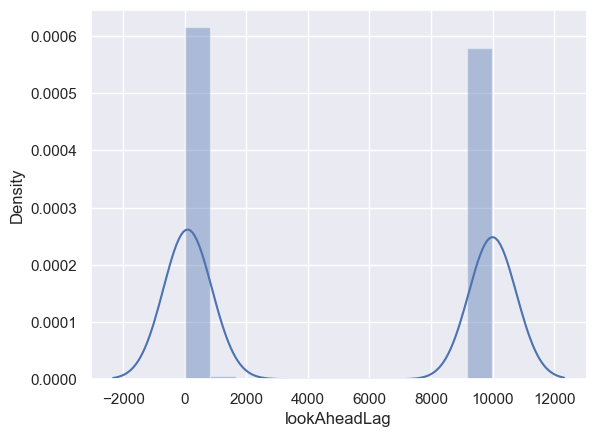

In [ ]:
sns.distplot(X.lookAheadLag)

/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='lookBackType1_', ylabel='lookAheadType_'>

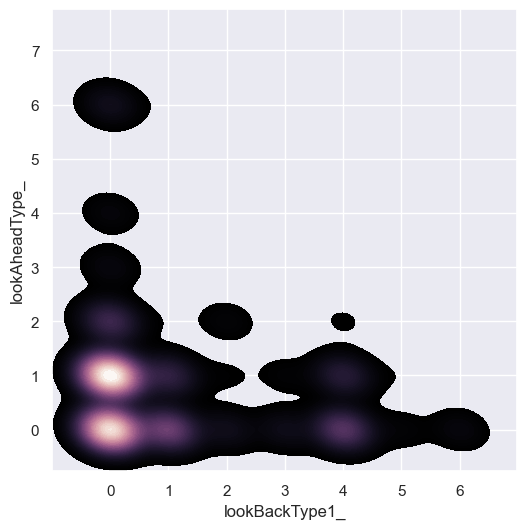

In [ ]:
f, ax = plt.subplots(figsize=(6, 6))
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
sns.kdeplot(X.lookBackType1_, X.lookAheadType_, cmap=cmap, n_levels=60, shade=True)

fenci 慢性病items 筛选 with unstructure-text feature 句长特征 text mining proprocessing

In [ ]:
stopWordFile = 'stopwords/stopwordsMerged.txt'

textText = pd.read_csv('textFile/recordText_5w.txt', dtype=object)

my_stopwords =  [i.strip() for i in open(stopWordFile, encoding='utf-8').readlines()]

textText['text_length'] = 0
textText['text_length'] = textText['record'].apply(lambda x:len(str(x)))
textText = textText[textText['text_length'] > 1]
textText = textText[textText['text_length'] <= 50]

#textText = textText[['review_seg']].replace('nan', ' ')

#complain
#advice

textText['record'] = textText['record'].astype(str)
textText['review_seg'] = textText['record'].apply(lambda x : ' '.join([j.strip() for j in jieba.lcut(x) if j not in my_stopwords]))

In [ ]:
len(textText)

9844

In [ ]:
# 筛除短文本 和 异常值 0.1-0.9
textText.text_length.quantile(0.1)

3.0

In [ ]:
ttt = pd.read_csv('chronicItem_indexed_Xt.csv', index_col=0)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

sns.set(color_codes=True)

In [ ]:
ttt = ttt[['lookAheadType_',
       'lookBackType1_', 'lookBackType2_', 'lookBackType3_',
       'consultingType_']]

/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='consultingType_', ylabel='Density'>

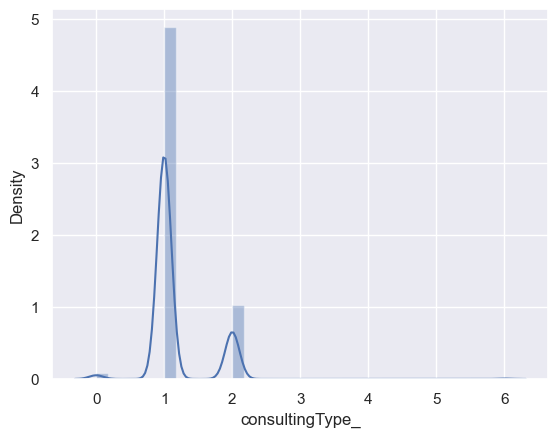

In [ ]:
sns.distplot(ttt.consultingType_)

/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='lookBackType3_', ylabel='lookAheadType_'>

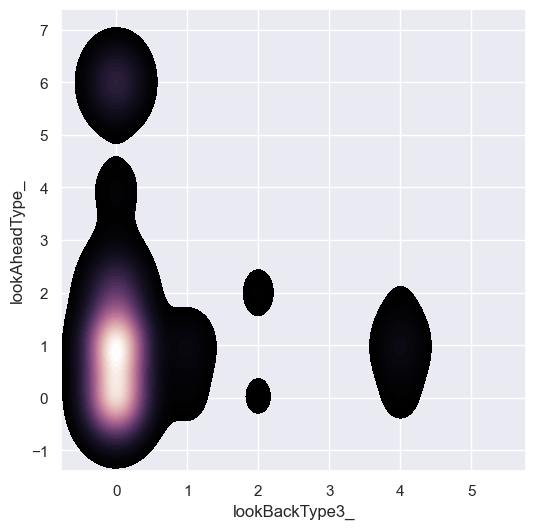

In [ ]:
f, ax = plt.subplots(figsize=(6, 6))
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
sns.kdeplot(ttt.lookBackType3_, ttt.lookAheadType_, cmap=cmap, n_levels=60, shade=True)

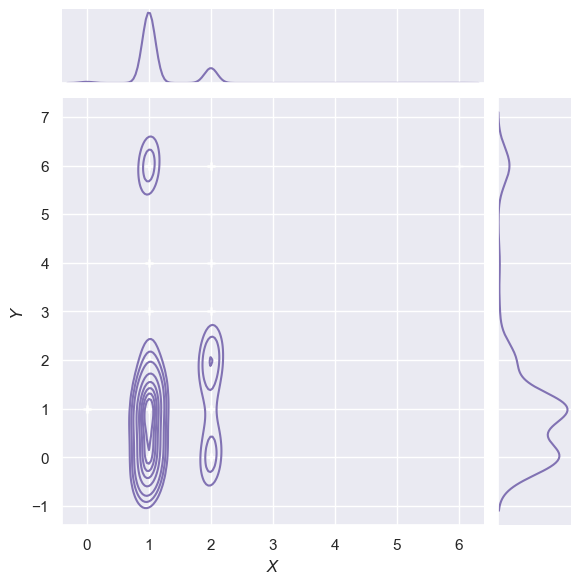

In [ ]:
g = sns.jointplot(x="consultingType_", y="lookAheadType_", data=ttt, kind="kde", color="m")
g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X$", "$Y$")

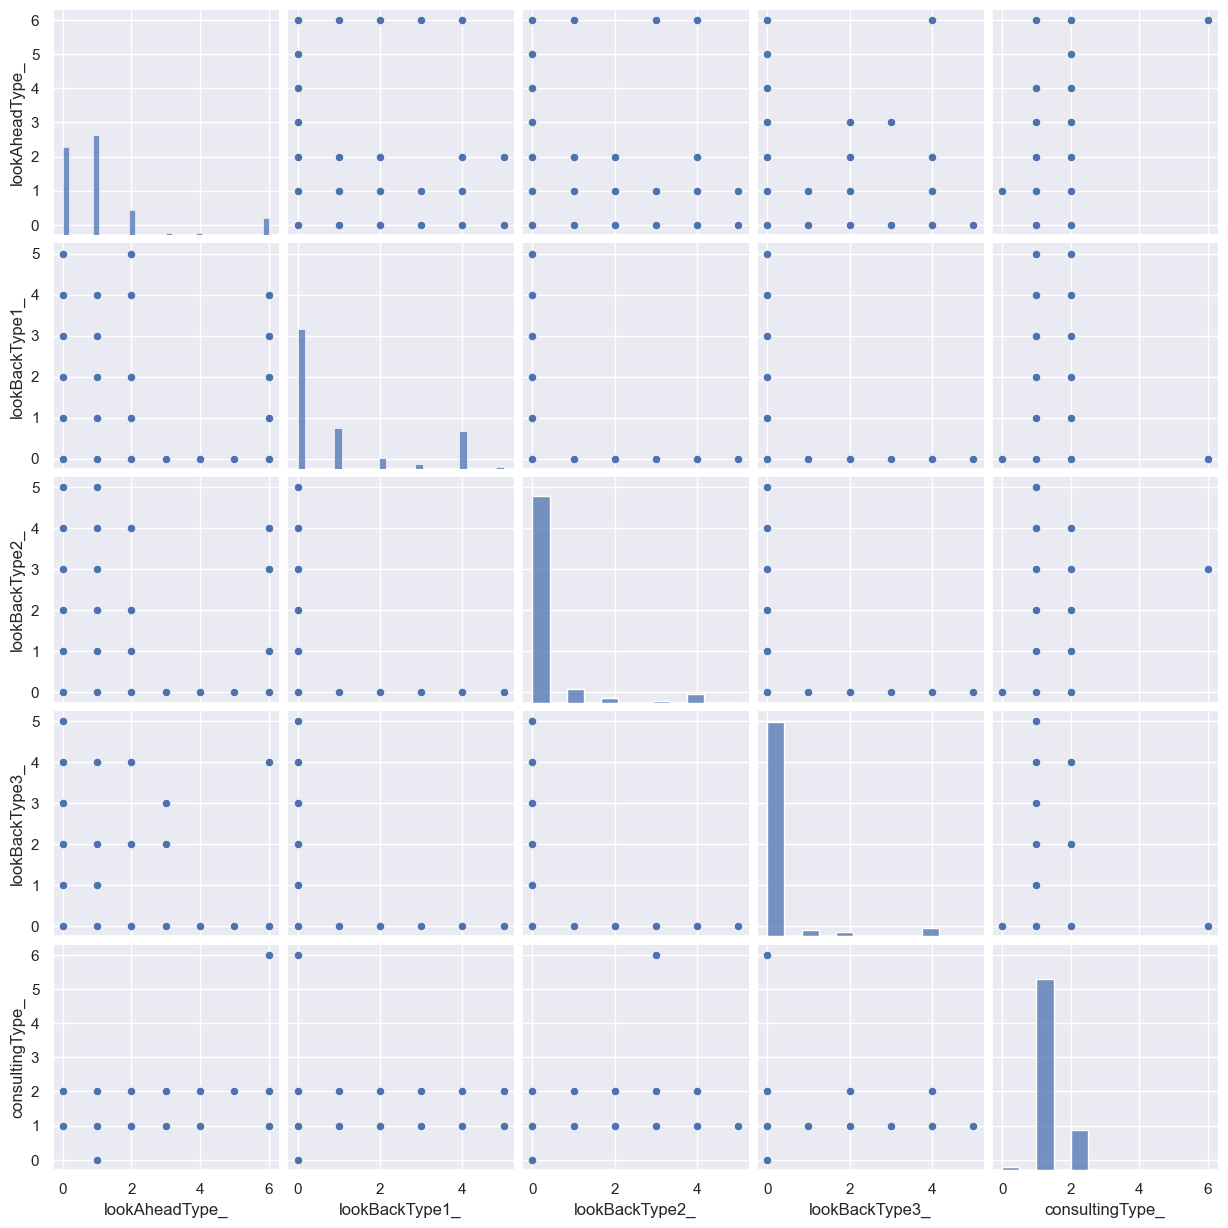

In [ ]:
sns.pairplot(ttt)

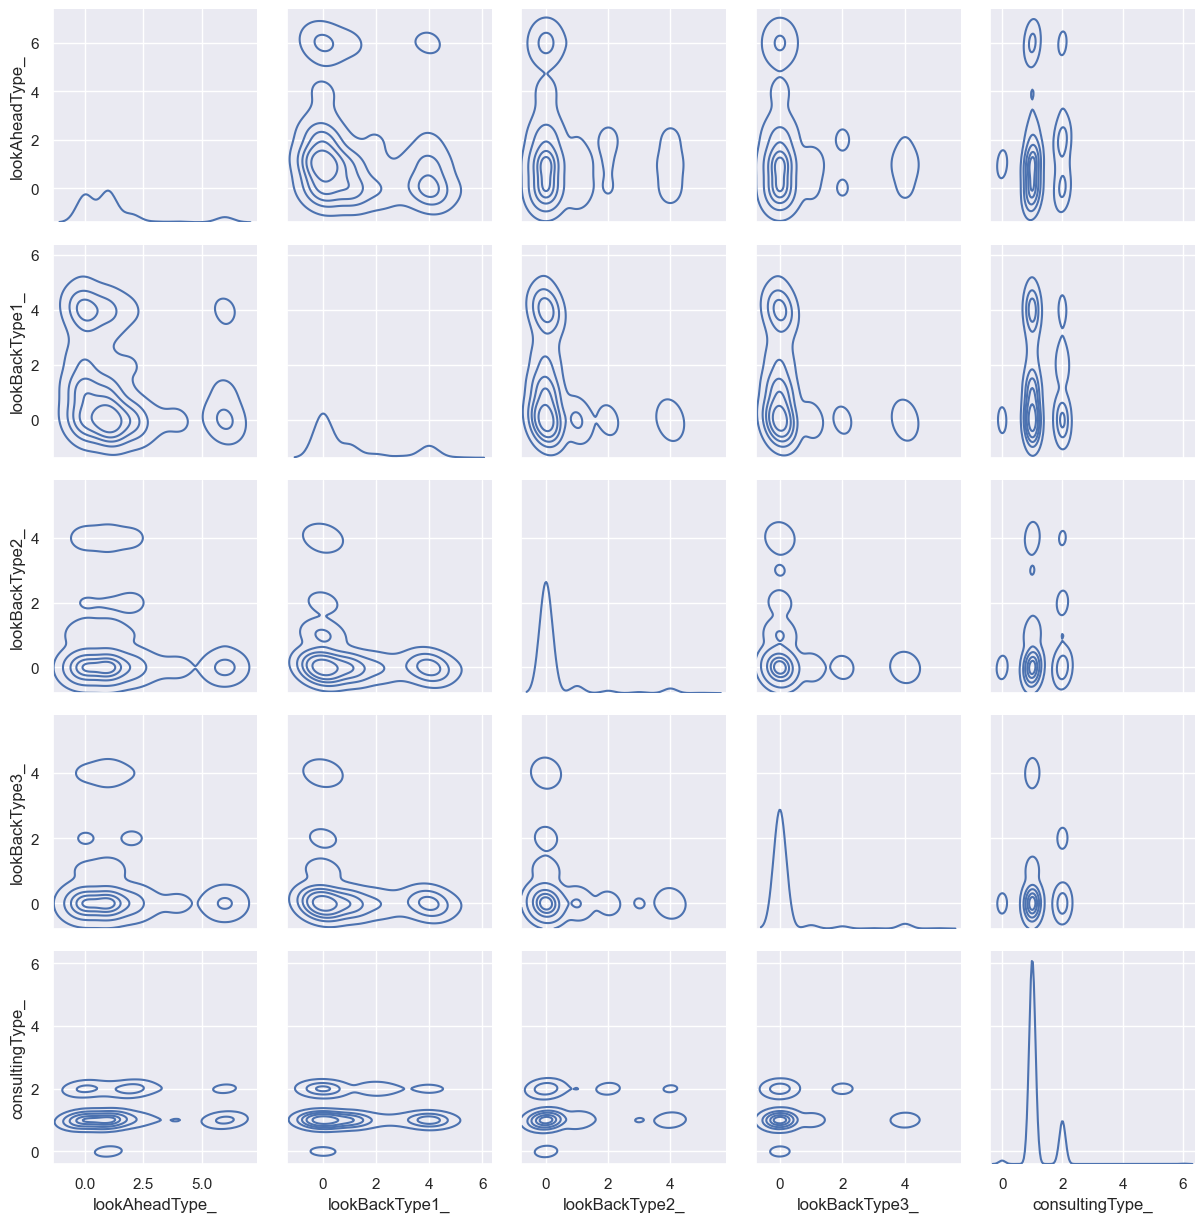

In [ ]:
g = sns.PairGrid(ttt)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, n_levels=6)

In [ ]:
textText = textText.rename(columns={'Unnamed: 0':'index'})
textText.to_csv("selectedRecordText_5w.csv", index = False, encoding = 'utf-8')

In [ ]:
ind_selectedText = list(textText.loc[(textText.text_length >= 3) & (textText.text_length <= 23)]['index'])
selectedText = textText[[i in ind_selectedText for i in textText['index']]]

#complaint
#advice
#askList
#answerList
#record
#checkInList

selectedText['record'] = selectedText['record'].astype(str)
selectedText['review_seg'] = selectedText['record'].apply(lambda x : ' '.join([j.strip() for j in jieba.lcut(x) if j not in my_stopwords]))

selectedText.to_csv("selectedRecordText_5w.csv", index = False, encoding = 'utf-8')

/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [ ]:
# selectedText = pd.read_csv('chronicRecord_38w.csv', index_col=0)

In [ ]:
# 依据领域知识聚类
# 提取患者人数较多的慢性病items 亲线上复诊的问诊记录 （复诊较多 线下转线上多，不紧急, 中药, 中成药）
#keyword1 = ['糖尿病','血糖','高血压','血压','心脏病','阻塞性肺气肿','慢阻肺','乙型','肝炎','慢性','肾病']
#keyword1 = ['糖尿','血糖','血压','心脏病','阻塞','慢阻','乙型','肝炎','慢性','肾病']
keyword1 = ['糖尿病']
keyword_2_g1 = ['综合症', '肾病', '综合征']
keyword_2_g2 = ['胃炎', '慢性', '萎缩性']
#keywordg1 = [肾病，血糖，血压]
#keywordg1 = [血压，控制，高血压]
keyword_2_g3 = ['乙型肝炎', '肝硬', '乙肝']
keyword_2_g4 = ['糖尿病', '妊娠期', '妊娠']
#keywordg1 = [激素，肾病，综合征]
keyword_2_g5 = ['高血压', '高血压病', '粥样']

pattern = re.compile('|'.join(keyword1))

# 外伤 手术 急性 等亲线下医疗服务的问诊记录
#keyword = ['外伤' '手术' '急性']
# 精神类
#keyword = ['心理', '精神', '抑郁', '焦虑', '精神病']

# 综合症/征？？？ 看bert

#result_findall = pattern.findall(fc['sstt'].to_list())
ind_chronic = list(textText.loc[textText['review_seg'].str.contains(pattern)]['index'])
chronicdata = textText[[i in ind_chronic for i in textText['index']]]
chronicdata.to_csv("tangniaobingRecord.csv", index = False, encoding = 'utf-8')

# second round to be continued ...

根据筛选过的index反查X

In [ ]:
chronicdata

,index,record,text_length,review_seg
100,100,膜性肾病糖尿病高血压,10,膜性 肾病 糖尿病 高血压
208,208,慢性肾衰糖尿病肾病,9,慢性 肾衰 糖尿病 肾病
247,247,妊娠期糖尿病监测咨询,10,妊娠期 糖尿病 监测 咨询
1146,1146,岁男性胆囊结石合并胆囊炎胆总管结石糖尿病咨询治疗方案,26,岁 男性 胆囊结石 合并 胆囊炎 胆总管 结石 糖尿病 咨询 治疗 方案
1241,1241,糖尿病,3,糖尿病
1740,1740,糖尿病咨询复查结果,9,糖尿病 咨询 复查
1859,1859,双眼糖尿病视网膜病变,10,双眼 糖尿病 视网膜 病变
1860,1860,妊娠期糖尿病产后三月余监测血糖正常,17,妊娠期 糖尿病 产后 三月 余 监测 血糖
2346,2346,糖尿病年目前怀孕周亚临床甲减现用门冬胰岛素三餐前各单位甘舒霖睡前今日查糖化血红蛋白甲功提示及正常,48,糖尿病 年 怀孕 周亚 临床 甲 减现 用门冬 胰岛素 三餐 前 单位 甘舒霖 睡前 今日 ...
2420,2420,目前主要问题是血压升高二百二一百三既往有高血压病糖尿病和睡眠障碍史,33,血压 升高 二百二 一百 三 高血压病 糖尿病 睡眠 障碍 史


In [ ]:
chronicItem = X.iloc[[int(i) for i in ind_chronic],:]
chronicItem.to_csv('tangniaobingRenshenRecordItem.csv')

In [ ]:
# from sklearn.cluster import KMeans
# import sys
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.cluster import KMeans
# from sklearn.datasets import make_blobs
# from sklearn import metrics

import umap.umap_ as umap


bertopic text embedding

In [ ]:
%%time
#chronicdata = pd.read_csv("chronicAdvice_38w.csv")

# cuda env
# model = SentenceTransformer(r'trueto/medbert-base-wwm-chinese', device='cuda')
model = SentenceTransformer('trueto/medbert-base-chinese')

## trueto/medalbert-base-wwm-chinese
## trueto/medalbert-base-chinese
# trueto/medbert-kd-chinese
# trueto/medbert-base-chinese

embeddings = model.encode(chronicdata['review_seg'].tolist(), show_progress_bar=True)

sys.setrecursionlimit(1000000)

umap_embeddings = umap.UMAP(n_neighbors=25,
                            n_components=10,
                            min_dist=0.00,
                            metric='cosine',
                            random_state=2020).fit_transform(embeddings)

cluster = hdbscan.HDBSCAN(min_cluster_size=30,
                          metric='euclidean',
                          cluster_selection_method='eom', 
                          prediction_data=True).fit(umap_embeddings)

umap_data = umap.UMAP(n_neighbors=15, 
                      n_components=2, 
                      min_dist=0.0,
                      metric='cosine').fit_transform(embeddings)

Some weights of the model checkpoint at /Users/luoqk/.cache/torch/sentence_transformers/trueto_medbert-base-chinese were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Batches: 100%|██████████| 2/2 [00:03<00:00,  1.81s/it]
OMP: Info 

CPU times: user 13.3 s, sys: 2.02 s, total: 15.3 s
Wall time: 19.9 s


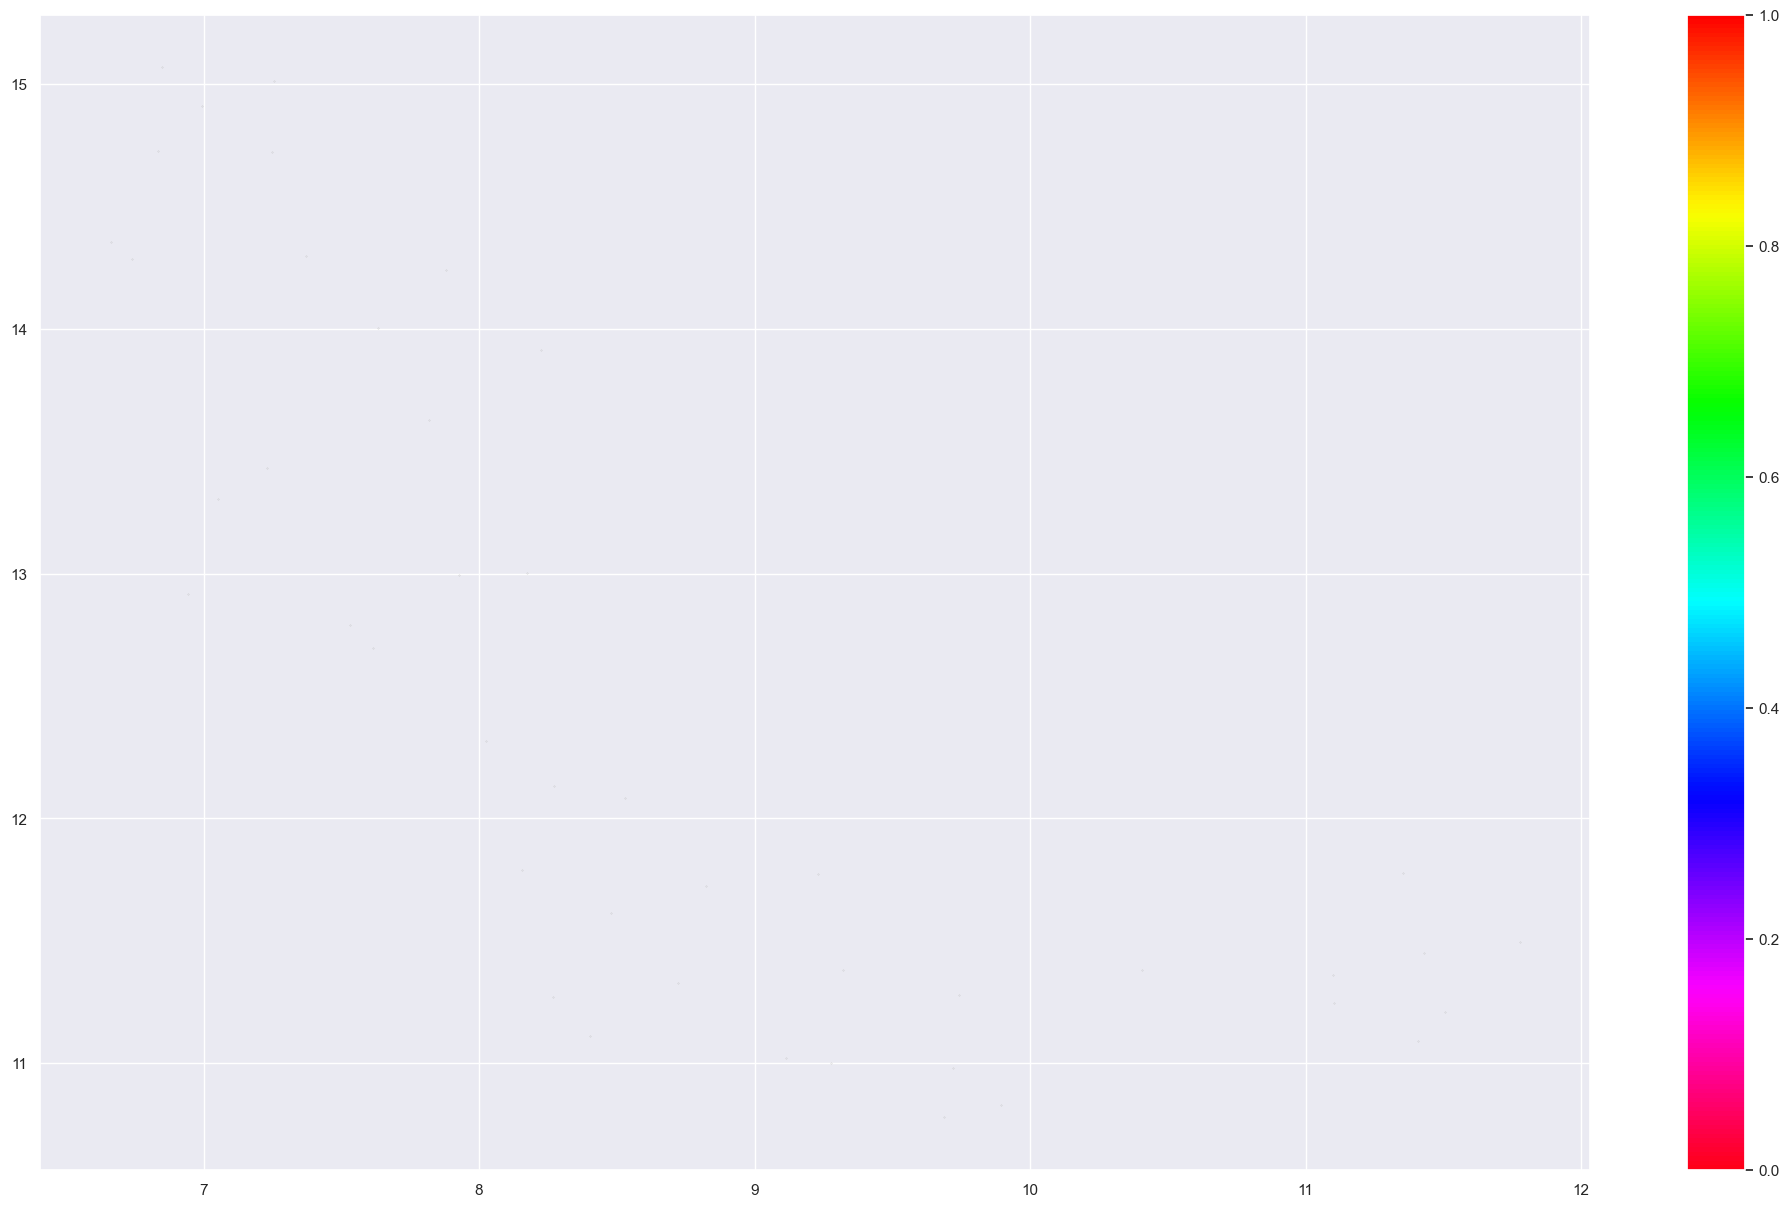

In [ ]:
# Prepare data
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(25, 15))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()
plt.savefig("umap_data.png", dpi = 600)

In [ ]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    my_stopwords =  [i.strip() for i in open(stopWordFile, encoding='utf-8').readlines()]
    """ Calculate a class-based TF-IDF where m is the number of total documents. """
    count = CountVectorizer(ngram_range=ngram_range, 
                            #tokenizer = lambda x : ' '.join(jieba.lcut(x)),
                            stop_words= my_stopwords).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

In [ ]:
docs_df = pd.DataFrame(chronicdata['review_seg'].tolist(), columns=["Doc"]) 
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [ ]:
len(docs_per_topic.Doc.tolist())

1

In [ ]:
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m = len(chronicdata))

/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ain', 'aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'lex', 'll', 'mon', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn', '①①', '①②', '①③', '①④', '①⑤', '①⑥', '①⑦', '①⑧', '①⑨', '①ａ', '①ｂ', '①ｃ', '①ｄ', '①ｅ', '①ｆ', '①ｇ', '①ｈ', '①ｉ', '①ｏ', '②①', '②②', '②③', '②④', '②⑤', '②⑥', '②⑦', '②⑧', '②⑩', '②ａ', '②ｂ', '②ｄ', '②ｅ', '②ｆ', '②ｇ', '②ｈ', '②ｉ', '②ｊ', '③①', '③⑩', '③ａ', '③ｂ', '③ｃ', '③ｄ', '③ｅ', '③ｆ', '③ｇ', '③ｈ', '④ａ', '④ｂ', '④ｃ', '④ｄ', '④ｅ', '⑤ａ', '⑤ｂ', '⑤ｄ', '⑤ｅ', '⑤ｆ', '１２', 'ｌｉ', 'ｚｘｆｉｔｌ'] not in stop_words.
  % sorted(inconsistent)


In [ ]:
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=10)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Topic,Size
0,-1,44


In [ ]:
top_n_words[-1][:10]

[('血糖', 0.05295455306189562),
 ('妊娠期', 0.05295455306189562),
 ('高血压', 0.04474797780831607),
 ('肾病', 0.04474797780831607),
 ('咨询', 0.04474797780831607),
 ('慢性', 0.03947152712425302),
 ('麻木', 0.03315527586728582),
 ('治疗', 0.03315527586728582),
 ('病史', 0.03315527586728582),
 ('监测', 0.03315527586728582)]

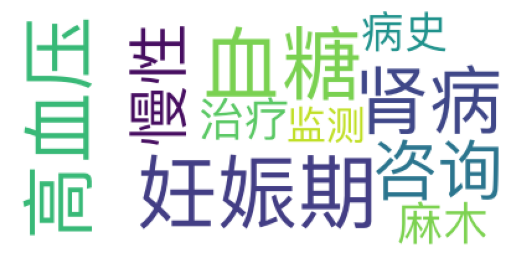

In [ ]:
from wordcloud import WordCloud
wordcloud = WordCloud(
    font_path="/System/Library/fonts/PingFang.ttc",
    max_words=100,
    background_color='white'
    #mask=backgroud_Image
    )

pos_wordcloud = wordcloud.fit_words(dict(top_n_words[-1][:10]))
plt.imshow(pos_wordcloud)
plt.axis('off') 
plt.show()

In [ ]:
from pprint import pprint
for i in list(range(len(top_n_words) - 1)):
    print('Most 20 Important words in TOPIC {} :\n'.format(i))
    pprint(top_n_words[i])
    pprint('***'*20)

In [ ]:
for i in tqdm(range(20)):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(chronicdata)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

  0%|          | 0/20 [00:00<?, ?it/s]/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ain', 'aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'lex', 'll', 'mon', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn', '①①', '①②', '①③', '①④', '①⑤', '①⑥', '①⑦', '①⑧', '①⑨', '①ａ', '①ｂ', '①ｃ', '①ｄ', '①ｅ', '①ｆ', '①ｇ', '①ｈ', '①ｉ', '①ｏ', '②①', '②②', '②③', '②④', '②⑤', '②⑥', '②⑦', '②⑧', '②⑩', '②ａ', '②ｂ', '②ｄ', '②ｅ', '②ｆ', '②ｇ', '②ｈ', '②ｉ', '②ｊ', '③①', '③⑩', '③ａ', '③ｂ', '③ｃ', '③ｄ', '③ｅ', '③ｆ', '③ｇ', '③ｈ', '④ａ', '④ｂ', '④ｃ', '④ｄ', '④ｅ', '⑤ａ', '⑤ｂ', '⑤ｄ', '⑤ｅ', '⑤ｆ', '１２', 'ｌｉ', 'ｚｘｆｉｔｌ'] not in stop_words.
  % sorted(inconsistent)
/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is

,Topic,Size
0,-1,3647
5,4,946
2,1,618
47,46,477
69,68,447
4,3,403
22,21,380
25,24,327
6,5,284
30,29,268


kmeans 聚类(training)

embedding similarity

In [ ]:
# cos_sim = util.cos_sim(embeddings, embeddings2)
# print("Cosine-Similarity:", cos_sim)

In [ ]:
#bert计算出来的向量集合并归一化
wv = pd.DataFrame(embeddings)
uv = np.linalg.norm(wv, axis=1).reshape(-1, 1)  # Unit Vector
wv = wv / uv 

# 聚类
Kmeans = KMeans(n_clusters=30).fit(wv)
#print(Kmeans.cluster_centers_)
print(Kmeans.inertia_)

In [ ]:
labels = kmeans.labels_
# y the lookahead consulting type
# check how many of the samples were correctly labeled
correct_labels = sum(y == labels)

print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y.size))
print('Accuracy score: {0:0.2f}'. format(correct_labels/float(y.size)))
# print(Kmeans.predict((x[:30,:])))
# # print(metrics.calinski_harabaz_score(x,y_predict))
# print(metrics.silhouette_score(x,y_predict))

lda model

In [ ]:
lda_model.print_topics(num_words=10)[0]

(29,
 '0.055*"痤疮" + 0.041*"升高" + 0.036*"乳腺" + 0.034*"疼痛" + 0.028*"分泌物" + 0.028*"可能性" + 0.026*"男性" + 0.026*"减退" + 0.022*"膝关节" + 0.020*"伤口"')

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                id2word=id2word,
                num_topics=30,
                # random_state=100,
                # update_every=1,
                # chunksize=100,
                # passes=10,
                # alpha='auto',
                # per_word_topics=True
                )

pprint(lda_model.print_topics(num_words=30))

# perplexity and coherence score

'''
模型复杂度和主题一致性提供了一种方便的方法来判断给定主题模型的好坏程度。
特别是主题一致性得分更有帮助。
'''
# def model():
# Compute Perplexity 模型复杂度
print('Perplexity: ', lda_model.log_perplexity(corpus)) # a measure of how good the model is. lower the better.

#coherence='umass'

In [ ]:
coherence_values = []
model_list = []
for num_topics in range(2,41,2):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                    id2word=id2word,
                    num_topics=num_topics,
                    # random_state=100,
                    # update_every=1,
                    # chunksize=100,
                    # passes=10,
                    # alpha='auto',
                    # per_word_topics=True
)
    model_list.append(lda_model)
    coherencemodel = CoherenceModel(model=lda_model, texts=fenciList, dictionary=id2word, coherence='c_v')
    coherence_values.append(round(coherencemodel.get_coherence(),3))

In [ ]:
sample_df = pd.DataFrame(columns=['askList', 'answerList', 'checkInList', 'timesCheckIn'])

sample_df['answerList'] = dialog['answerList']
sample_df['askList'] = dialog['askList']
sample_df['checkInList'] = dialog['checkInList']
sample_df['timesCheckIn'] = dialog['timesCheckIn']

trainDf = pd.DataFrame(columns=['answerText', 'askText', 'fullText', 'times'])
trainDf['answerText'] = sample_df['answerList'] + sample_df['checkInList']
trainDf['askText'] = sample_df['askList'] + sample_df['checkInList']
trainDf['fullText'] = sample_df['answerList'] + sample_df['checkInList'] + sample_df['askList']
trainDf['checkInText'] = sample_df['checkInList']
trainDf['times'] = sample_df['timesCheckIn']

print(len(trainDf['answerText']))
print(len(trainDf['answerText'].isnull() == False))

43475
43475


In [ ]:
# def embedding_sentences(sentence):
#     #preprocess model
#     preprocessor = hub.KerasLayer('dataset/BERT/bert_zh_preprocess_3/')
#     encoder_inputs = preprocessor(sentence)
#     #bert model
#     encoder = hub.KerasLayer('dataset/BERT/bert_zh_L-12_H-768_A-12_4/', trainable=True)
#     outputs = encoder(encoder_inputs)
#     pooled_output = outputs["pooled_output"]
#     print('embedding finished')
#     return pooled_output

In [ ]:
#encodeAnswer = embedding_sentences(sample_df['answerList'])
# encodeAsk = embedding_sentences(sample_df['askList'])
# encodeCheckIn = embedding_sentences(sample_df['checkInList'])

#pd.DataFrame(encodeAnswer.numpy()).to_csv('encodeAnswer.csv')
# pd.DataFrame(encodeAsk.numpy()).to_csv('encodeAsk.csv')
# pd.DataFrame(encodeCheckIn.numpy()).to_csv('encodeCheckIn.csv')

In [ ]:
# encode = np.asarray(encode).astype(np.float32)

In [ ]:
# encode = tf.convert_to_tensor(encode, dtype=tf.float32) 

In [ ]:
#trainDf['times'] = trainDf['times'].astype(float)

In [ ]:
#from sklearn.preprocessing import OneHotEncoder
#from sklearn.preprocessing import LabelEncoder
#sample_df[['timesCheckIn']] = sample_df[['timesCheckIn']].astype(str)
#onehot=OneHotEncoder(sparse=False)
#labelEnc = LabelEncoder()
#sample_df['timesCheckIn'] = labelEnc.fit_transform(sample_df[['timesCheckIn']])
trainDf['times'] = trainDf['times'].map(trainDf['times'].value_counts())

quantVal = list()
for i in range(3):
    quantVal.append(trainDf['times'].quantile([0.25,0.50,0.75]).values[i])

def freqFunc(x):
    if x >= quantVal[2]:
#'mostWithInitial'
        return 3
    if x >= quantVal[1] and x < quantVal[2] :
#'manyWithSubsequent'
        return 2
    if x >= quantVal[0] and x < quantVal[1] :
#'someWithinRepeat'
        return 1
    else:
#'fewInCycles'
        return 0

trainDf['times']= trainDf['times'].apply(lambda x: freqFunc(x))

#trainDf['times'].to_csv('labelTimesCheckIn.csv', header = None)
#tempCsv = pd.read_csv('labelTimesCheckIn.csv',header=None, names=['serial','times'])
#tempCsv.to_csv('labelTimesCheckIn.csv', index=False)

# data1 = pd.get_dummies(sample_df[["timesCheckIn"]])
# res  = sample_df.join(data1)
# data1.columns.values

# sample_df[['timesCheckIn']].head(30)

In [ ]:
import torch
import transformers
from sklearn.model_selection import train_test_split
from transformers import AutoModel, BertTokenizerFast

In [ ]:
trainDf = trainDf[['checkInText', 'times']]

GridSearchCV

In [ ]:
##multi classification 时候用
#from sklearn.model_selection import GridSearchCV, ShuffleSplit
# X = trainDf['checkInText']
# y = trainDf['times']
# shuffle_split = ShuffleSplit(n_splits=10, test_size=0.3)

# # GridSearch without CV
# params = { 'n_estimators': [16, 32] }
# clf = RandomForestClassifier()
# grid_search = GridSearchCV(clf, param_grid=params, cv=shuffle_split)
# grid_search.fit(X, y)

In [ ]:
# from sklearnex import patch_sklearn
# patch_sklearn()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(trainDf['checkInText'], trainDf['times'], stratify=trainDf['times'], random_state=2)

bert = AutoModel.from_pretrained('trueto/medbert-base-chinese')
tokenizer = BertTokenizerFast.from_pretrained('trueto/medbert-base-chinese')
train_idx = x_train.dropna().index
test_idx = x_test.dropna().index

train_tokens = tokenizer.batch_encode_plus(x_train[train_idx].to_list(),
                                           max_length = 50,
                                           add_special_tokens = True,
                                           pad_to_max_length = True,
                                           truncation = True)
test_tokens = tokenizer.batch_encode_plus(x_test[test_idx].to_list(),
                                           max_length = 50,
                                           add_special_tokens = True,
                                           pad_to_max_length = True,
                                           truncation = True)

train_seq = torch.tensor(train_tokens['input_ids'])
train_mask = torch.tensor(train_tokens['attention_mask'])
train_y = torch.tensor(y_train[train_idx].to_list())

test_seq = torch.tensor(test_tokens['input_ids'])
test_mask = torch.tensor(test_tokens['attention_mask'])
test_y = torch.tensor(y_test[test_idx].to_list())

Some weights of the model checkpoint at trueto/medbert-base-chinese were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/Users/luoqk/opt/anaconda3/envs/nlp/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2263: Fut

In [ ]:
from torch.utils.data import TensorDataset, RandomSampler, DataLoader
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
trainloader = DataLoader(train_data, 
                         sampler = train_sampler,
                         batch_size = 32)

test_data = TensorDataset(test_seq, test_mask, test_y)
test_sampler = RandomSampler(test_data)
testloader = DataLoader(test_data, 
                         sampler = test_sampler,
                         batch_size = 32)

for param in bert.parameters():
    param.requires_grad = False

making our model

In [ ]:
from torch import nn
from transformers import AdamW
import torch.nn.functional as F
from sklearn.utils.class_weight import compute_class_weight

class BertClassifier(nn.Module):
    def __init__(self, bert):
        super().__init__()
        self.bert = bert
        self.fc1 = nn.Linear(768,4)
    
    def forward(self, sent_id, mask):
        _ , cls_hs = self.bert(sent_id, attention_mask = mask, return_dict=False)
        return F.log_softmax(self.fc1(cls_hs), dim = 1)

In [ ]:
model = BertClassifier(bert)
#model = model.cuda()
optimizer = AdamW(model.parameters(), lr = 1e-5)

/Users/luoqk/opt/anaconda3/envs/nlp/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train), y = y_train)

class_weights
#cw = dict(enumerate(class_weights))

array([1.036559  , 2.36824521, 1.33850575, 0.53593031])

In [ ]:
weights = torch.tensor(class_weights, dtype = torch.float)
#weights = weights.cuda()

criterion = nn.NLLLoss(weight = weights)

tuning our model

In [ ]:
from tqdm.notebook import tqdm

epochs = 10

for e in range(epochs):   
    train_loss = 0.0
    for batch in tqdm(trainloader):
        #batch = [i.cuda() for i in batch]
        batch = [i for i in batch]
        sent_id, masks, labels = batch

        optimizer.zero_grad()
        preds = model(sent_id, masks)
        loss = criterion(preds, labels)
        train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
    print(f'Epoch:{e+1}\t\tTraining Loss: {train_loss / len(trainloader)}')
    pred_label, true_label = [], []
    for batch in tqdm(testloader):
        batch = [i for i in batch]
        sent_id, masks, labels = batch
        preds = model(sent_id, masks)
        pred_label.extend(torch.argmax(preds, axis = 1).cpu())
        true_label.extend(labels.cpu())
    assert (len(true_label) == 4)
    acc = (true_label == pred_label).sum() / len(true_label)
    print(f'Epoch:{e+1}\t\tTraining Accuracy: {acc / len(testloader)}')

  0%|          | 0/1019 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# pred_label = []
# true_label = []
# for batch in tqdm(testloader):
#     batch = [i for i in batch]
#     sent_id, masks, labels = batch
#     preds = model(sent_id, masks)
#     pred_label.extend(torch.argmax(preds, axis = 1).cpu())
#     true_label.extend(labels.cpu())

  0%|          | 0/1359 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
confusion_matrix(true_label, pred_label)

array([[1393,    6,  521,  701],
       [ 630,    2,  230,  285],
       [ 881,    8,  425,  716],
       [ 438,    4,  481, 4148]])

In [ ]:
print(classification_report(true_label, pred_label))

              precision    recall  f1-score   support

           0       0.42      0.53      0.47      2621
           1       0.10      0.00      0.00      1147
           2       0.26      0.21      0.23      2030
           3       0.71      0.82      0.76      5071

    accuracy                           0.55     10869
   macro avg       0.37      0.39      0.37     10869
weighted avg       0.49      0.55      0.51     10869



In [ ]:
trueList = []
predList = []
for i in range(len(true_label)):
    trueList.append(true_label[i].item())

for j in range(len(pred_label)):
    predList.append(pred_label[j].item())

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 4

# Binarize the output 将类别标签二值化
trueList = label_binarize(trueList, classes=[0, 1, 2, 3])
predList = label_binarize(predList, classes=[0, 1, 2, 3])
# one vs rest方式计算每个类别的TPR/FPR以及AUC
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(trueList[:, i], predList[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

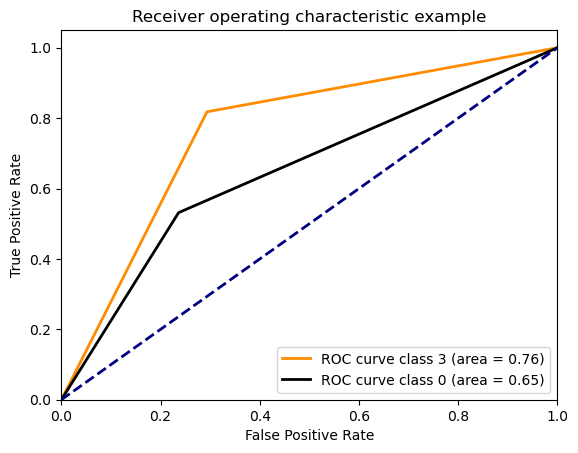

/var/folders/83/5mt2ybjd1456sxc35hrpt6_40000gn/T/ipykernel_18899/1210432067.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


{0: 0.6475884133265193, 1: 0.49994610413613544, 2: 0.5349886614238175, 3: 0.7622175592954655, 'micro': 0.6993897015978163, 'macro': 0.6111851845454845}
micro auc: 0.6993897015978163
macro auc: 0.6111851845454844


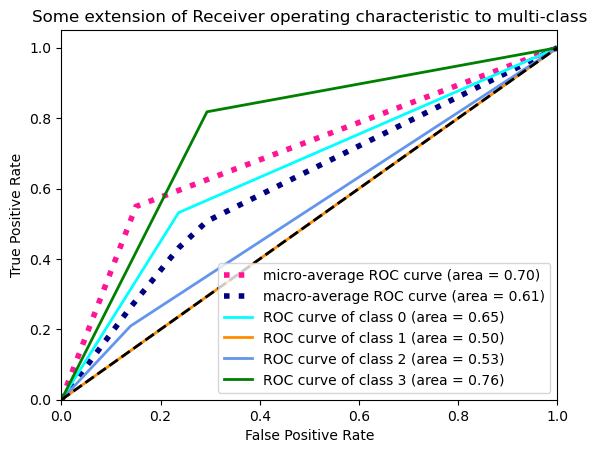

In [ ]:
import matplotlib.pyplot as plt
from scipy import interp

# Compute micro-average ROC curve and ROC area
# 微平均方式计算TPR/FPR，最后得到AUC

fpr["micro"], tpr["micro"], _ = roc_curve(trueList.ravel(), predList.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# 直接调用函数计算
micro_auc = roc_auc_score(trueList, predList, average='micro')

lw = 2
plt.figure()
plt.plot(fpr[3], tpr[3], color='darkorange', lw=lw, label='ROC curve class 3 (area = %0.2f)' % roc_auc[3])
plt.plot(fpr[0], tpr[0], color='black', lw=lw, label='ROC curve class 0 (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
# 直接调用函数计算
macro_auc = roc_auc_score(trueList, predList, average='macro')

print(roc_auc)
print('micro auc:', micro_auc)
print('macro auc:', macro_auc)

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
            color='navy', linestyle=':', linewidth=4)

colors = ['aqua', 'darkorange', 'cornflowerblue', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#dataConsulting = pd.concat([pd.DataFrame(encodeAsk), sample_df[['timesCheckIn']]], axis=1)
encodeTensor = pd.read_csv('encodeAnswer.csv')
label = pd.read_csv('labelTimesCheckIn.csv')

dataResponse = pd.concat([encodeTensor, label[['times']]], axis=1)
# dataResponse = dataResponse.values.astype(np.float32)
#dataVisit = pd.concat([pd.DataFrame(encodeCheckIn), sample_df[['timesCheckIn']]], axis=1)
dataResponse = dataResponse.drop(columns='Unnamed: 0')

In [ ]:
train, test = train_test_split(dataResponse, test_size=0.2,random_state=42)
train, val = train_test_split(train, test_size=0.2,random_state=42)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

In [ ]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('Times')
    ds = tf.data.Dataset.from_tensor_slices((dataframe, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

In [ ]:
batch_size = 16
train_dataset = df_to_dataset(train, batch_size=batch_size)
val_dataset = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_dataset = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [ ]:
model = tf.keras.Sequential()
#model.add(tf.keras.layers.Reshape((-1,), input_shape=(768,)))
model.add(tf.keras.layers.Dense(256, activation='relu',input_shape=(768,),name='layer1'))
model.add(tf.keras.layers.Dense(128, activation='relu',name='layer2'))
model.add(tf.keras.layers.Dropout(0.2, name='dropout'))
model.add(tf.keras.layers.Dense(1, activation='softmax',name='output'))

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True, show_layer_activations=True)

In [ ]:
METRICS = [

tf.keras.metrics.TruePositives(name='tp'),

tf.keras.metrics.FalsePositives(name='fp'),

tf.keras.metrics.TrueNegatives(name='tn'),

tf.keras.metrics.FalseNegatives(name='fn'),

tf.keras.metrics.Precision(name='precision'),

tf.keras.metrics.Recall(name='recall'),

tf.keras.metrics.CategoricalAccuracy(name='acc'),

tf.keras.metrics.AUC(name='auc'),

]

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(0.001),
              loss = 'categorical_crossentropy',
              #metrics = METRICS
              metrics = ['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=100, validation_data=val_dataset, verbose=1)

evaluation

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print("Accuracy", accuracy)

In [ ]:
result = pd.DataFrame(history.history)
#k = max(result.categorical_accuracy)
#result[result.categorical_accuracy==k]

In [ ]:
import matplotlib.pyplot as plt
# 创建一段时间内准确性和损失的图表
# dict_keys（['val_acc'，'val_loss'，'acc'，'loss']）
history_dict = history.history

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 第二张图表
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
#保存模型
model.save('./model/response_classifier')
#加载模型
model = tf.keras.models.load_model('./model/response_classifier')

ValueError: x and y must have same first dimension, but have shapes (20,) and (3,)

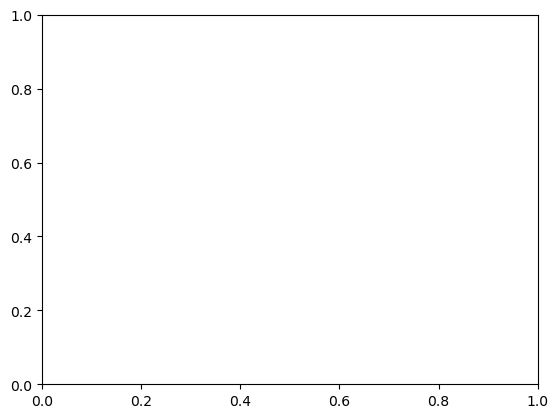

In [ ]:
# 利用可视化的方式进行展示
x = range(2,41,2)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# 展示不同的主题数对应的一致性分数
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of nan
Num Topics = 4  has Coherence Value of nan
Num Topics = 6  has Coherence Value of nan
Num Topics = 8  has Coherence Value of nan
Num Topics = 10  has Coherence Value of nan
Num Topics = 12  has Coherence Value of nan
Num Topics = 14  has Coherence Value of nan
Num Topics = 16  has Coherence Value of nan
Num Topics = 18  has Coherence Value of nan
Num Topics = 20  has Coherence Value of nan


In [ ]:
# ----------------------------------------在每个句子中找到主要话题--------------------------------------------
# 每个文档都包含多个主题。但是，通常只有一个主题是主导的。下面的代码为每个句子提取该主要主题，并在格式正确的输出中显示该主题和关键字的权重。
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num),                 round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    # print(contents)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    # print(sent_topics_df)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=fenciList)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
# df_dominant_topic.to_excel(path+'resultsdatas.xlsx',index=False)
df_dominant_topic.head(10)

In [ ]:
# -----------------------------------------每个主题中最具有代表性的句子-----------------------------------------
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
grp.sort_values(['Perc_Contribution'], ascending=False).head(1)],
axis=0)

# Reset Index
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

In [ ]:
df_dominant_topic = df_dominant_topic.dropna(axis=0)
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=600)
plt.hist(doc_lens, bins = 300, color='navy')
plt.text(250, 400, "Mean : " + str(round(np.mean(doc_lens))))
plt.text(250, 300, "Median : " + str(round(np.median(doc_lens))))
plt.text(250, 200, "Stdev : " + str(round(np.std(doc_lens))))
plt.text(250, 100, "1%ile : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(250, 50, "99%ile : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 300),ylim=(0, 800), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,400,5))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=10))
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()] # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

In [ ]:
pyLDAvis.enable_notebook() 
vis_data = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
pyLDAvis.show(vis_data, open_browser=False)
pyLDAvis.save_html(vis_data, 'save_local.html')

In [ ]:
# 利用可视化的方式进行展示
x = range(2,41,2)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# 展示不同的主题数对应的一致性分数
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [ ]:
# 根据一致性得分，选择具有最高CV的模型，选择的主题数是
# 选择模型并打印主题
optimal_model = model_list[15]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))